# Multilevel Elasticities for a Single SKU

In this notebook I want to experiment with some basic models for price elasticity estimation in the simple context of a simple [sku](https://en.wikipedia.org/wiki/Stock_keeping_unit) across multiple stores and regions. The motivation is to have a concrete example of the elasticity models presented in the Chapter 11: Big Data Pricing Models of the book [Pricing Analytics](https://www.routledge.com/Pricing-Analytics-Models-and-Advanced-Quantitative-Techniques-for-Product/Paczkowski/p/book/9781138623934) by [Walter R. Paczkowski](https://www.linkedin.com/in/walter-paczkowski-a17a1511/)

## Elasticity Definition

Here I provide a very succinct definition of elasticity (there is a vast literature on this topic, see the reference above).  The elasticity of a variable $y(x, z)$ with respect to another variable $x$ is defined as the percentage change in $y$ for a one percent change in $x$.  Mathematically, this is written as 
$$
\eta = \frac{\partial \log(y(x, z))}{\partial \log(x)}
$$

**Example (log-log model):**
For example, if $y(x) = ax^{b}$, then $\log(y(x)) = \log(a) + b\log(x)$, which therefore implies $\eta = b$ (this is referred as a log-log model). In this specific example the elasticity is constant.

**Example (linear model):**
Now let us assume a linear relation $y = a + bx$. Hence, from the chain rule, we have

$$
\eta = \frac{\partial \log(y(x))}{\partial \log(x)} = \frac{1}{y(x)}\frac{\partial y(x)}{\partial \log(x)} = \frac{1}{y(x)}x\frac{\partial y(x)}{\partial x} = \frac{xb}{y(x)}
$$

---

## Part 1: Data Generating Process

In this first part we study the data generating process in detail. This is important because it helps us understand the explicit assumptions we are making about the data and therefore how to build a model that is consistent with these assumptions.

**Business Setting**: We have a single sku across many stores across multiple regions. Each store has limited historical data regarding price and demand change over time. We want to estimate the price elasticity of demand for this sku in each store. We expect these elasticities differ across regions because of inherent differences in consumer income.

### Prepare Notebook

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns

from numpy.typing import NDArray
from pydantic import BaseModel, Field, model_validator, field_validator
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
seed: int = sum(map(ord, "multilevel_elasticities_single_sku"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

### Entities Definition

The main objective of this first part is to generate data for each store. We want to generate price and demand data which reflects the heterogeneity of the regions, which have different *media income* which should have a considerable impact in consumer behavior.

Let us use [`pydantic`](https://docs.pydantic.dev/latest/) to define the entities of our model. We will define the following entities:

In [4]:
class Sku(BaseModel):
    id: int = Field(..., ge=0)
    prices: NDArray[np.float_]
    quantities: NDArray[np.float_]

    class Config:
        arbitrary_types_allowed = True

    @field_validator("prices", "quantities")
    def validate_gt_0(cls, value):
        if (value <= 0).any():
            raise ValueError("prices and quantities must be positive")
        return value

    @field_validator("prices", "quantities")
    def validate_size_gt_0(cls, value):
        if value.size == 0:
            raise ValueError("prices and quantities must have at least one element")
        return value

    @model_validator(mode="before")
    def validate_sizes(cls, values):
        if values["prices"].size != values["quantities"].size:
            raise ValueError("prices and quantities must have the same size")
        return values

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(
            data={
                "item_id": self.id,
                "price": self.prices,
                "quantities": self.quantities,
                "time_step": np.arange(self.prices.size)[::-1],
            }
        )


class Store(BaseModel):
    id: int = Field(..., ge=0)
    items: list[Sku] = Field(..., min_items=1)

    @field_validator("items")
    def validate_item_ids(cls, value):
        if len({item.id for item in value}) != len(value):
            raise ValueError("items must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([item.to_dataframe() for item in self.items], axis=0)
        df["store_id"] = self.id
        df["region_store_id"] = f"r-{self.id}_s-" + df["store_id"].astype(str)
        return df.reset_index(drop=True)


class Region(BaseModel):
    id: int = Field(..., ge=0)
    stores: list[Store] = Field(..., min_items=1)
    median_income: float = Field(..., gt=0)

    @field_validator("stores")
    def validate_store_ids(cls, value):
        if len({store.id for store in value}) != len(value):
            raise ValueError("stores must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([store.to_dataframe() for store in self.stores], axis=0)
        df["region_id"] = self.id
        df["median_income"] = self.median_income
        return df.reset_index(drop=True)


class Market(BaseModel):
    regions: list[Region] = Field(..., min_items=1)

    @field_validator("regions")
    def validate_region_ids(cls, value):
        if len({region.id for region in value}) != len(value):
            raise ValueError("regions must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([region.to_dataframe() for region in self.regions], axis=0)
        return df.reset_index(drop=True).assign(
            log_price=lambda x: np.log(x["price"]),
            log_quantities=lambda x: np.log(x["quantities"]),
            region_id=lambda x: x["region_id"].astype("category"),
            region_store_id=lambda x: x["region_store_id"].astype("category"),
        )


### Model Specification

### Data Generating Process 

In [4]:
class LinearRegressionConfig(BaseModel):
    intercept: float
    slope: float
    sigma: float = Field(..., gt=0)


class MultiLevelElasticitiesDataGenerator(BaseModel):
    rng: np.random.Generator
    n_regions: int = Field(..., gt=0)
    time_range_mu: float = Field(..., gt=0)
    time_range_sigma: float = Field(..., gt=0)
    n_stores_per_region_mu: float = Field(..., gt=0)
    n_stores_per_region_sigma: float = Field(..., gt=0)
    median_income_per_region_mu: float = Field(..., gt=0)
    median_income_per_region_sigma: float = Field(..., gt=0)
    intercepts_lr_config: LinearRegressionConfig
    slopes_lr_config: LinearRegressionConfig
    price_mu: float = Field(..., gt=0)
    price_sigma: float = Field(..., gt=0)
    epsilon: float = Field(..., gt=0)

    class Config:
        arbitrary_types_allowed = True

    def get_n_stores_per_region_draws(self) -> NDArray:
        n_stores_per_region_dist = pm.NegativeBinomial.dist(
            mu=self.n_stores_per_region_mu, alpha=self.n_stores_per_region_sigma
        )
        n_stores_per_region_draws = pm.draw(
            n_stores_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return n_stores_per_region_draws + 2

    def get_median_income_per_region_draws(self) -> NDArray:
        median_income_per_region_dist = pm.Gamma.dist(
            mu=self.median_income_per_region_mu,
            sigma=self.median_income_per_region_sigma,
        )
        median_income_per_region_draws = pm.draw(
            median_income_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return median_income_per_region_draws + 1

    def get_store_time_range(self) -> int:
        time_range_dist = pm.NegativeBinomial.dist(
            mu=self.time_range_mu, alpha=self.time_range_sigma
        )
        time_range_samples = pm.draw(
            vars=time_range_dist, draws=1, random_seed=self.rng
        ).item()
        return time_range_samples + 2

    def get_alpha_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        alpha_j_dist = pm.Normal.dist(
            mu=self.intercepts_lr_config.intercept
            + self.intercepts_lr_config.slope * median_income_per_region,
            sigma=self.intercepts_lr_config.sigma,
        )
        return pm.draw(alpha_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_beta_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        beta_j_dist = pm.Normal.dist(
            mu=self.slopes_lr_config.intercept
            + self.slopes_lr_config.slope * median_income_per_region,
            sigma=self.slopes_lr_config.sigma,
        )
        return pm.draw(beta_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_prices_samples(self, store_time_range: int) -> NDArray:
        price_dist = pm.Gamma.dist(
            mu=self.price_mu,
            sigma=self.price_sigma,
        )
        return pm.draw(price_dist, draws=store_time_range, random_seed=self.rng)

    def get_quantities_samples(
        self, alpha_j_samples, beta_j_samples, prices_samples
    ) -> NDArray:
        log_quantities_dist = pm.Normal.dist(
            mu=alpha_j_samples + beta_j_samples * np.log(prices_samples),
            sigma=self.epsilon,
        )
        log_quantities_samples = pm.draw(
            log_quantities_dist, draws=1, random_seed=self.rng
        )
        return np.exp(log_quantities_samples)

    def create_store(self, id: int, median_income_per_region: float) -> Store:
        store_time_range = self.get_store_time_range()
        alpha_j_samples = self.get_alpha_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        beta_j_samples = self.get_beta_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        prices_samples = self.get_prices_samples(store_time_range=store_time_range)
        quantities_samples = self.get_quantities_samples(
            alpha_j_samples=alpha_j_samples,
            beta_j_samples=beta_j_samples,
            prices_samples=prices_samples,
        )
        return Store(
            id=id,
            items=[Sku(id=0, prices=prices_samples, quantities=quantities_samples)],
        )

    def create_region(
        self, id: int, n_stores_per_region: int, median_income_per_region: float
    ) -> Region:
        stores: list[Store] = [
            self.create_store(id=i, median_income_per_region=median_income_per_region)
            for i in range(n_stores_per_region)
        ]
        return Region(id=id, stores=stores, median_income=median_income_per_region)

    def run(self) -> Market:
        n_stores_per_region_draws = self.get_n_stores_per_region_draws()
        median_income_per_region_draws = self.get_median_income_per_region_draws()

        regions: list[Region] = [
            self.create_region(
                id=j,
                n_stores_per_region=n_stores_per_region_draws[j],
                median_income_per_region=median_income_per_region_draws[j],
            )
            for j in tqdm(range(self.n_regions))
        ]

        return Market(regions=regions)


In [5]:
data_generator = MultiLevelElasticitiesDataGenerator(
    rng=rng,
    n_regions=8,
    time_range_mu=20,
    time_range_sigma=5,
    n_stores_per_region_mu=16,
    n_stores_per_region_sigma=2,
    median_income_per_region_mu=5,
    median_income_per_region_sigma=2,
    intercepts_lr_config=LinearRegressionConfig(intercept=1, slope=0.3, sigma=0.02),
    slopes_lr_config=LinearRegressionConfig(intercept=-0.1, slope=-0.6, sigma=0.02),
    price_mu=1.5,
    price_sigma=0.25,
    epsilon=0.3,
)


In [6]:
market = data_generator.run()


  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
market_df = market.to_dataframe()

market_df.head(10)

item_id     price  quantities  time_step  store_id region_store_id  \
0        0  1.335446    6.170862         16         0         r-0_s-0   
1        0  1.702792    3.715124         15         0         r-0_s-0   
2        0  1.699778    3.290962         14         0         r-0_s-0   
3        0  1.335844    5.702928         13         0         r-0_s-0   
4        0  1.517213    4.264949         12         0         r-0_s-0   
5        0  1.434605    4.585819         11         0         r-0_s-0   
6        0  1.572367    2.684652         10         0         r-0_s-0   
7        0  1.579389    3.075871          9         0         r-0_s-0   
8        0  1.084296   20.707145          8         0         r-0_s-0   
9        0  1.081592   12.207531          7         0         r-0_s-0   

   region_id  median_income  
0          0       5.873343  
1          0       5.873343  
2          0       5.873343  
3          0       5.873343  
4          0       5.873343  
5          0       5.873343  
6          0       5.873343  
7          0       5.873343  
8          0       5.873343  
9          0       5.873343

In [8]:
market_df = market_df

### EDA

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Price vs Quantities by Region')

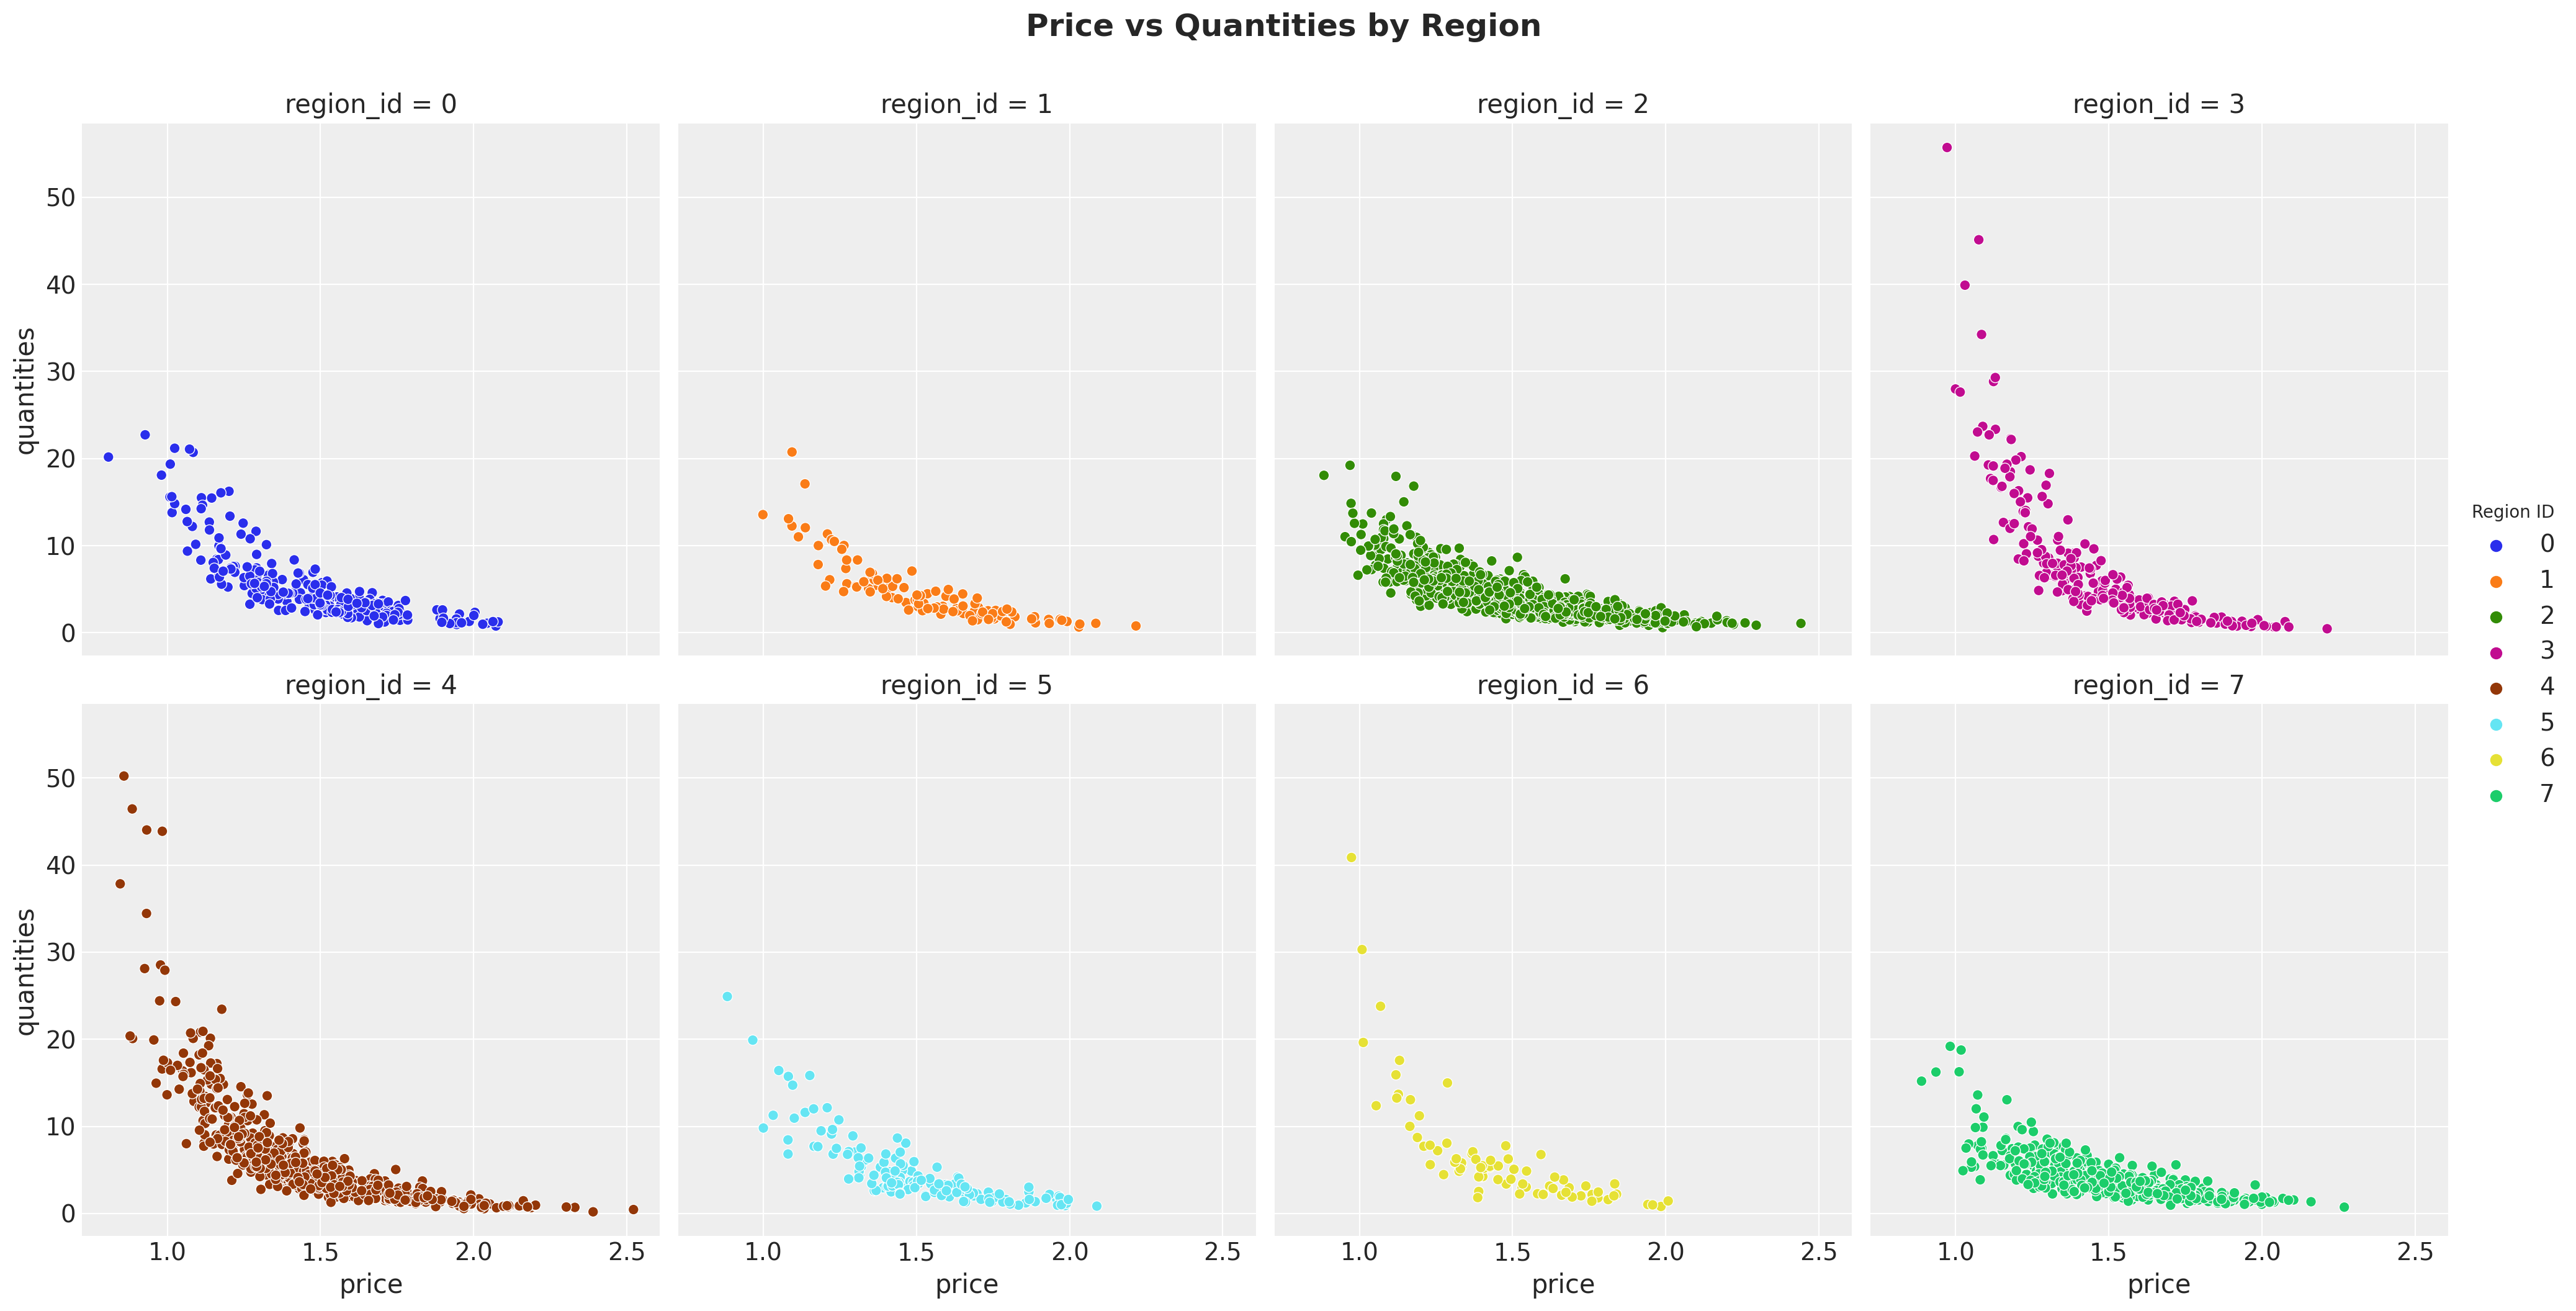

In [9]:
g = sns.relplot(
    data=market_df,
    x="price",
    y="quantities",
    kind="scatter",
    col="region_id",
    col_wrap=4,
    hue="region_id",
    facet_kws={"sharex": True, "sharey": True},
)
legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle("Price vs Quantities by Region", y=1.05, fontsize=18, fontweight="bold")

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Log Price vs Log Quantities by Region')

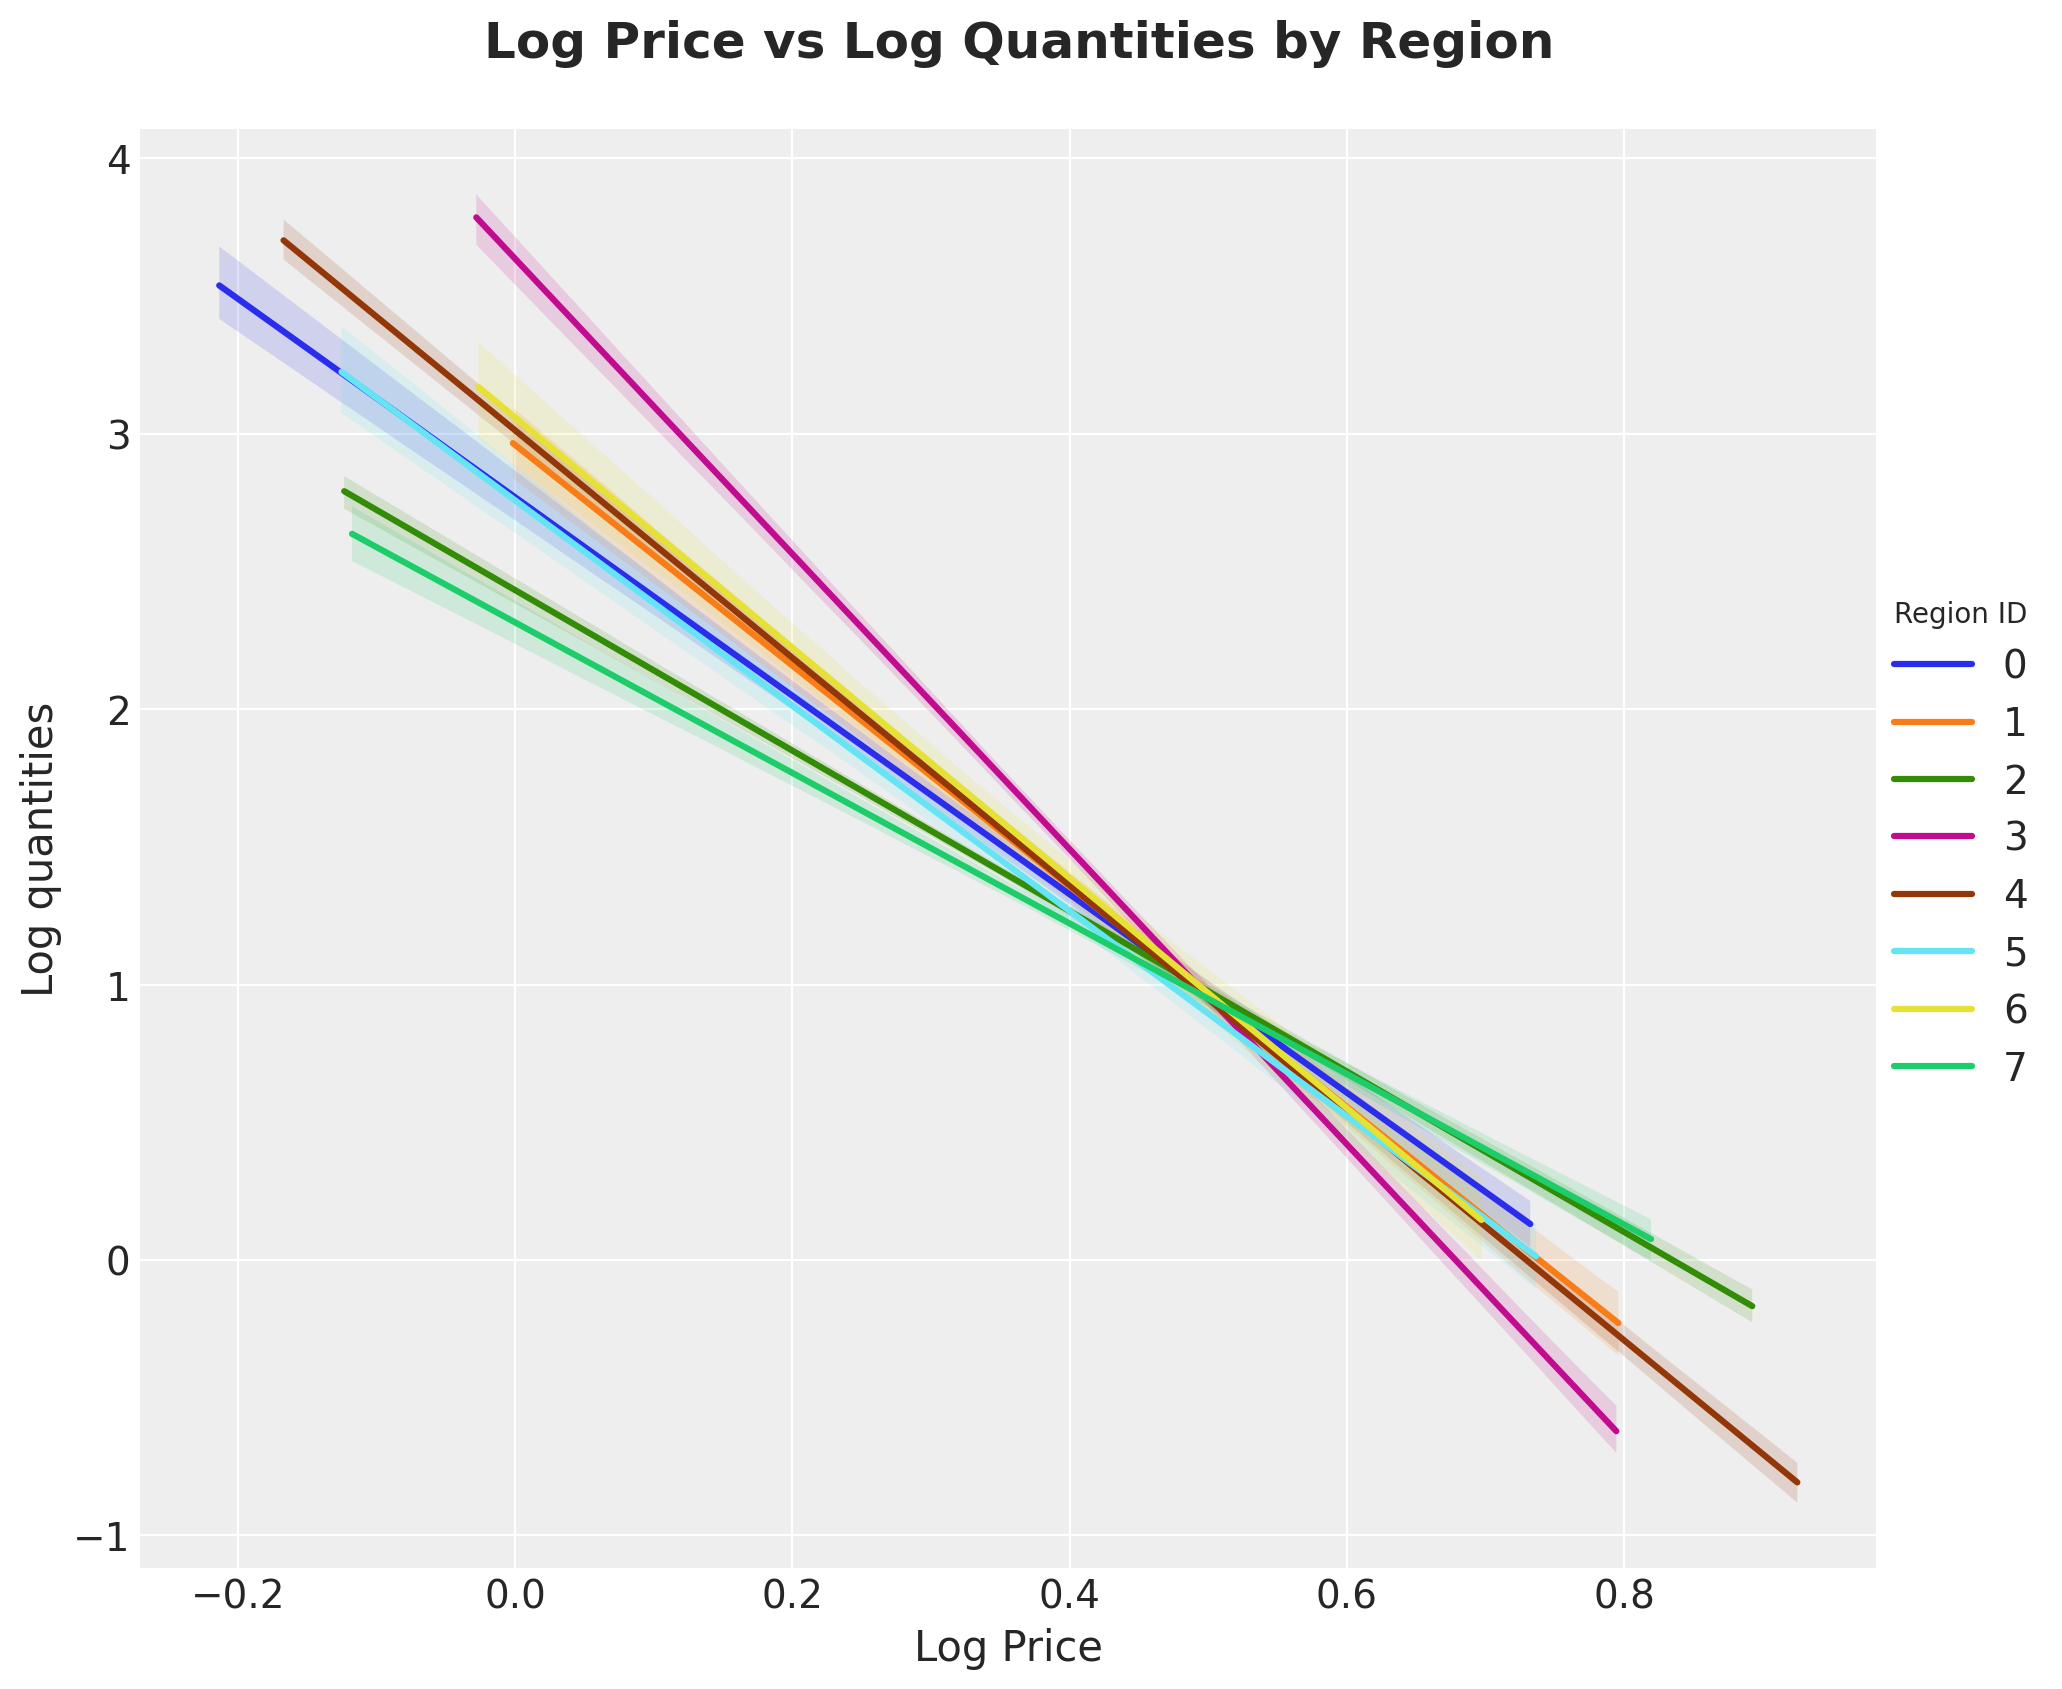

In [10]:
g = sns.lmplot(
    data=market_df,
    x="log_price",
    y="log_quantities",
    hue="region_id",
    height=8,
    aspect=1.2,
    scatter=False,
)
g.set_axis_labels(x_var="Log Price", y_var="Log quantities")
legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle(
    "Log Price vs Log Quantities by Region", y=1.05, fontsize=18, fontweight="bold"
)

Text(0.5, 1.0, 'Median Income by Region')

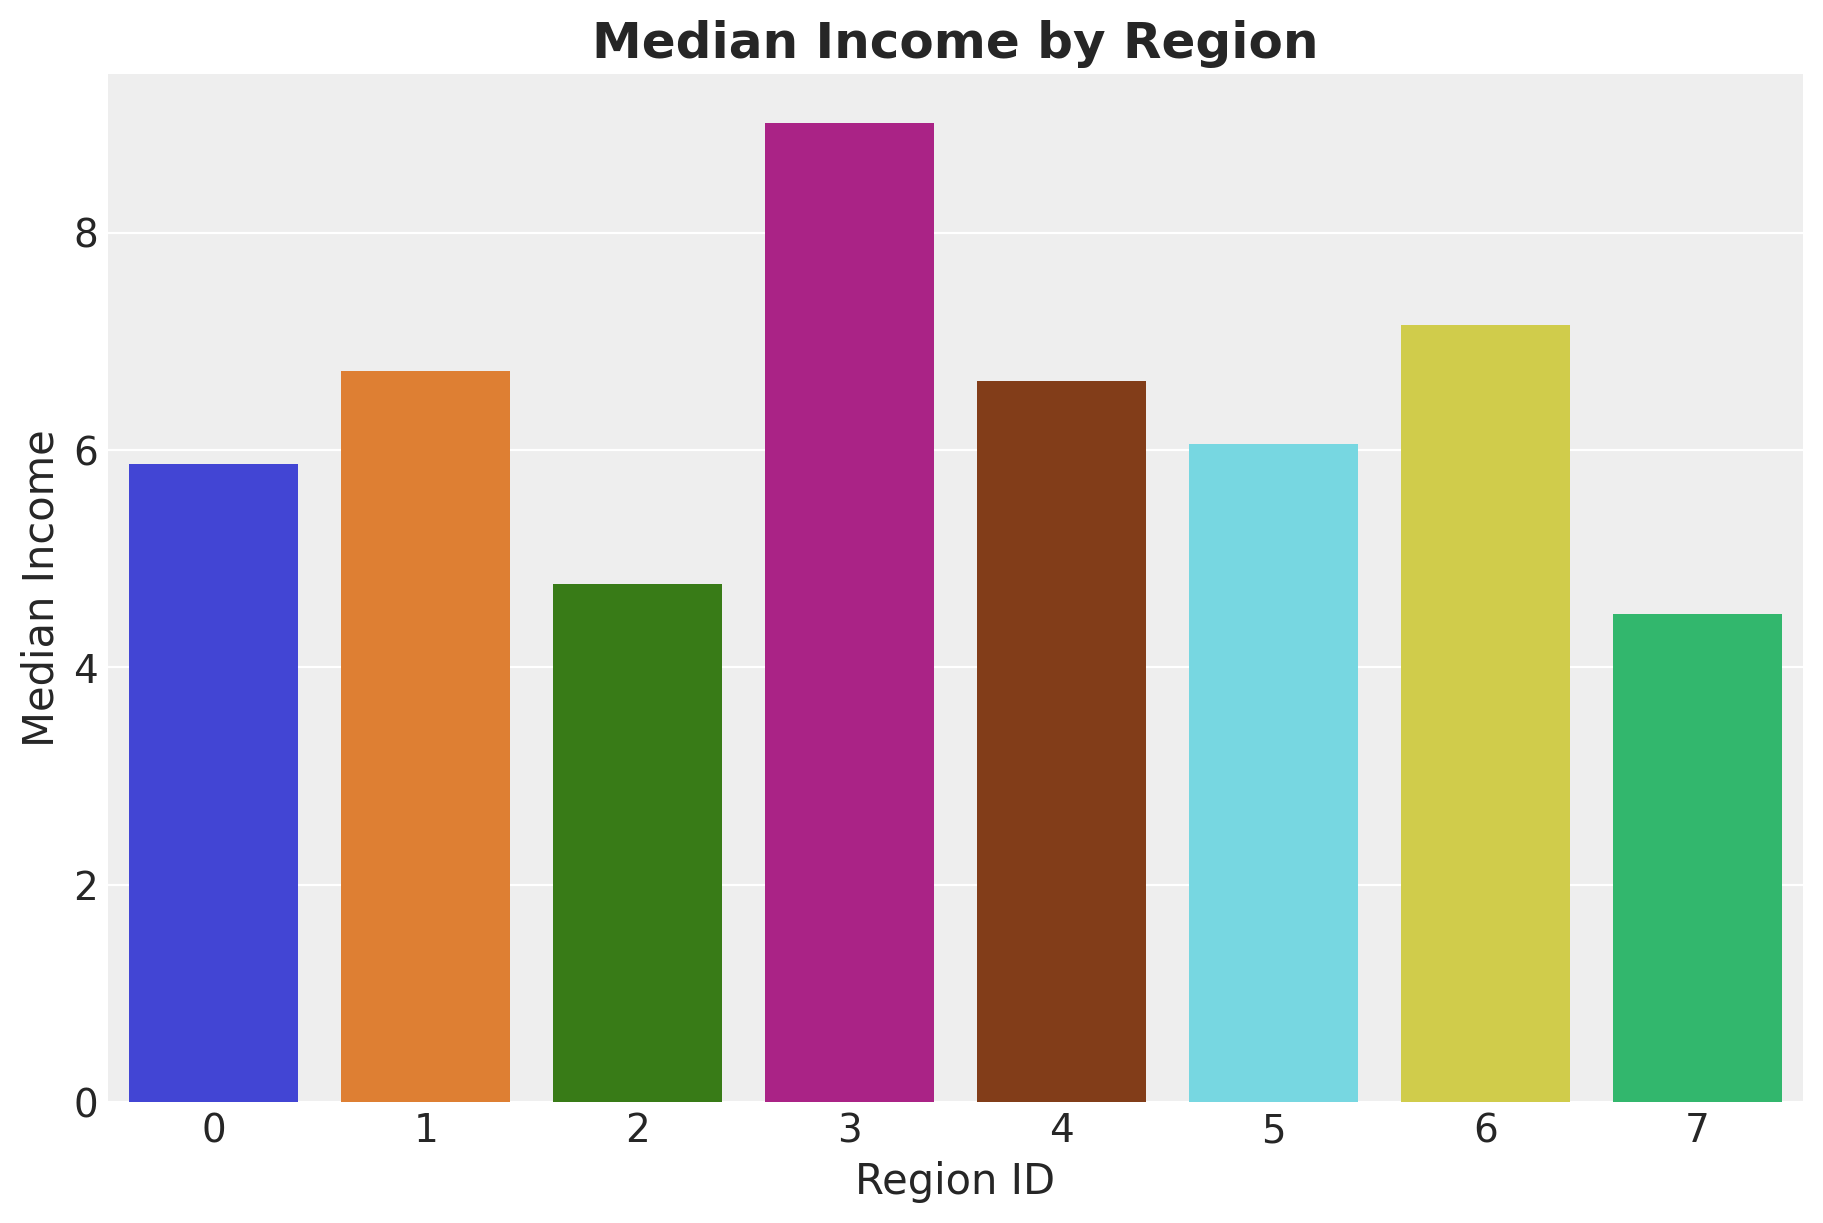

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
(
    market_df.groupby("region_id", as_index=False)
    .agg({"median_income": np.mean})
    .pipe((sns.barplot, "data"), x="region_id", y="median_income", ax=ax)
)
ax.set(xlabel="Region ID", ylabel="Median Income")
ax.set_title(label="Median Income by Region", fontsize=18, fontweight="bold")

Text(0.5, 1.0, 'Price by Store in Region 6')

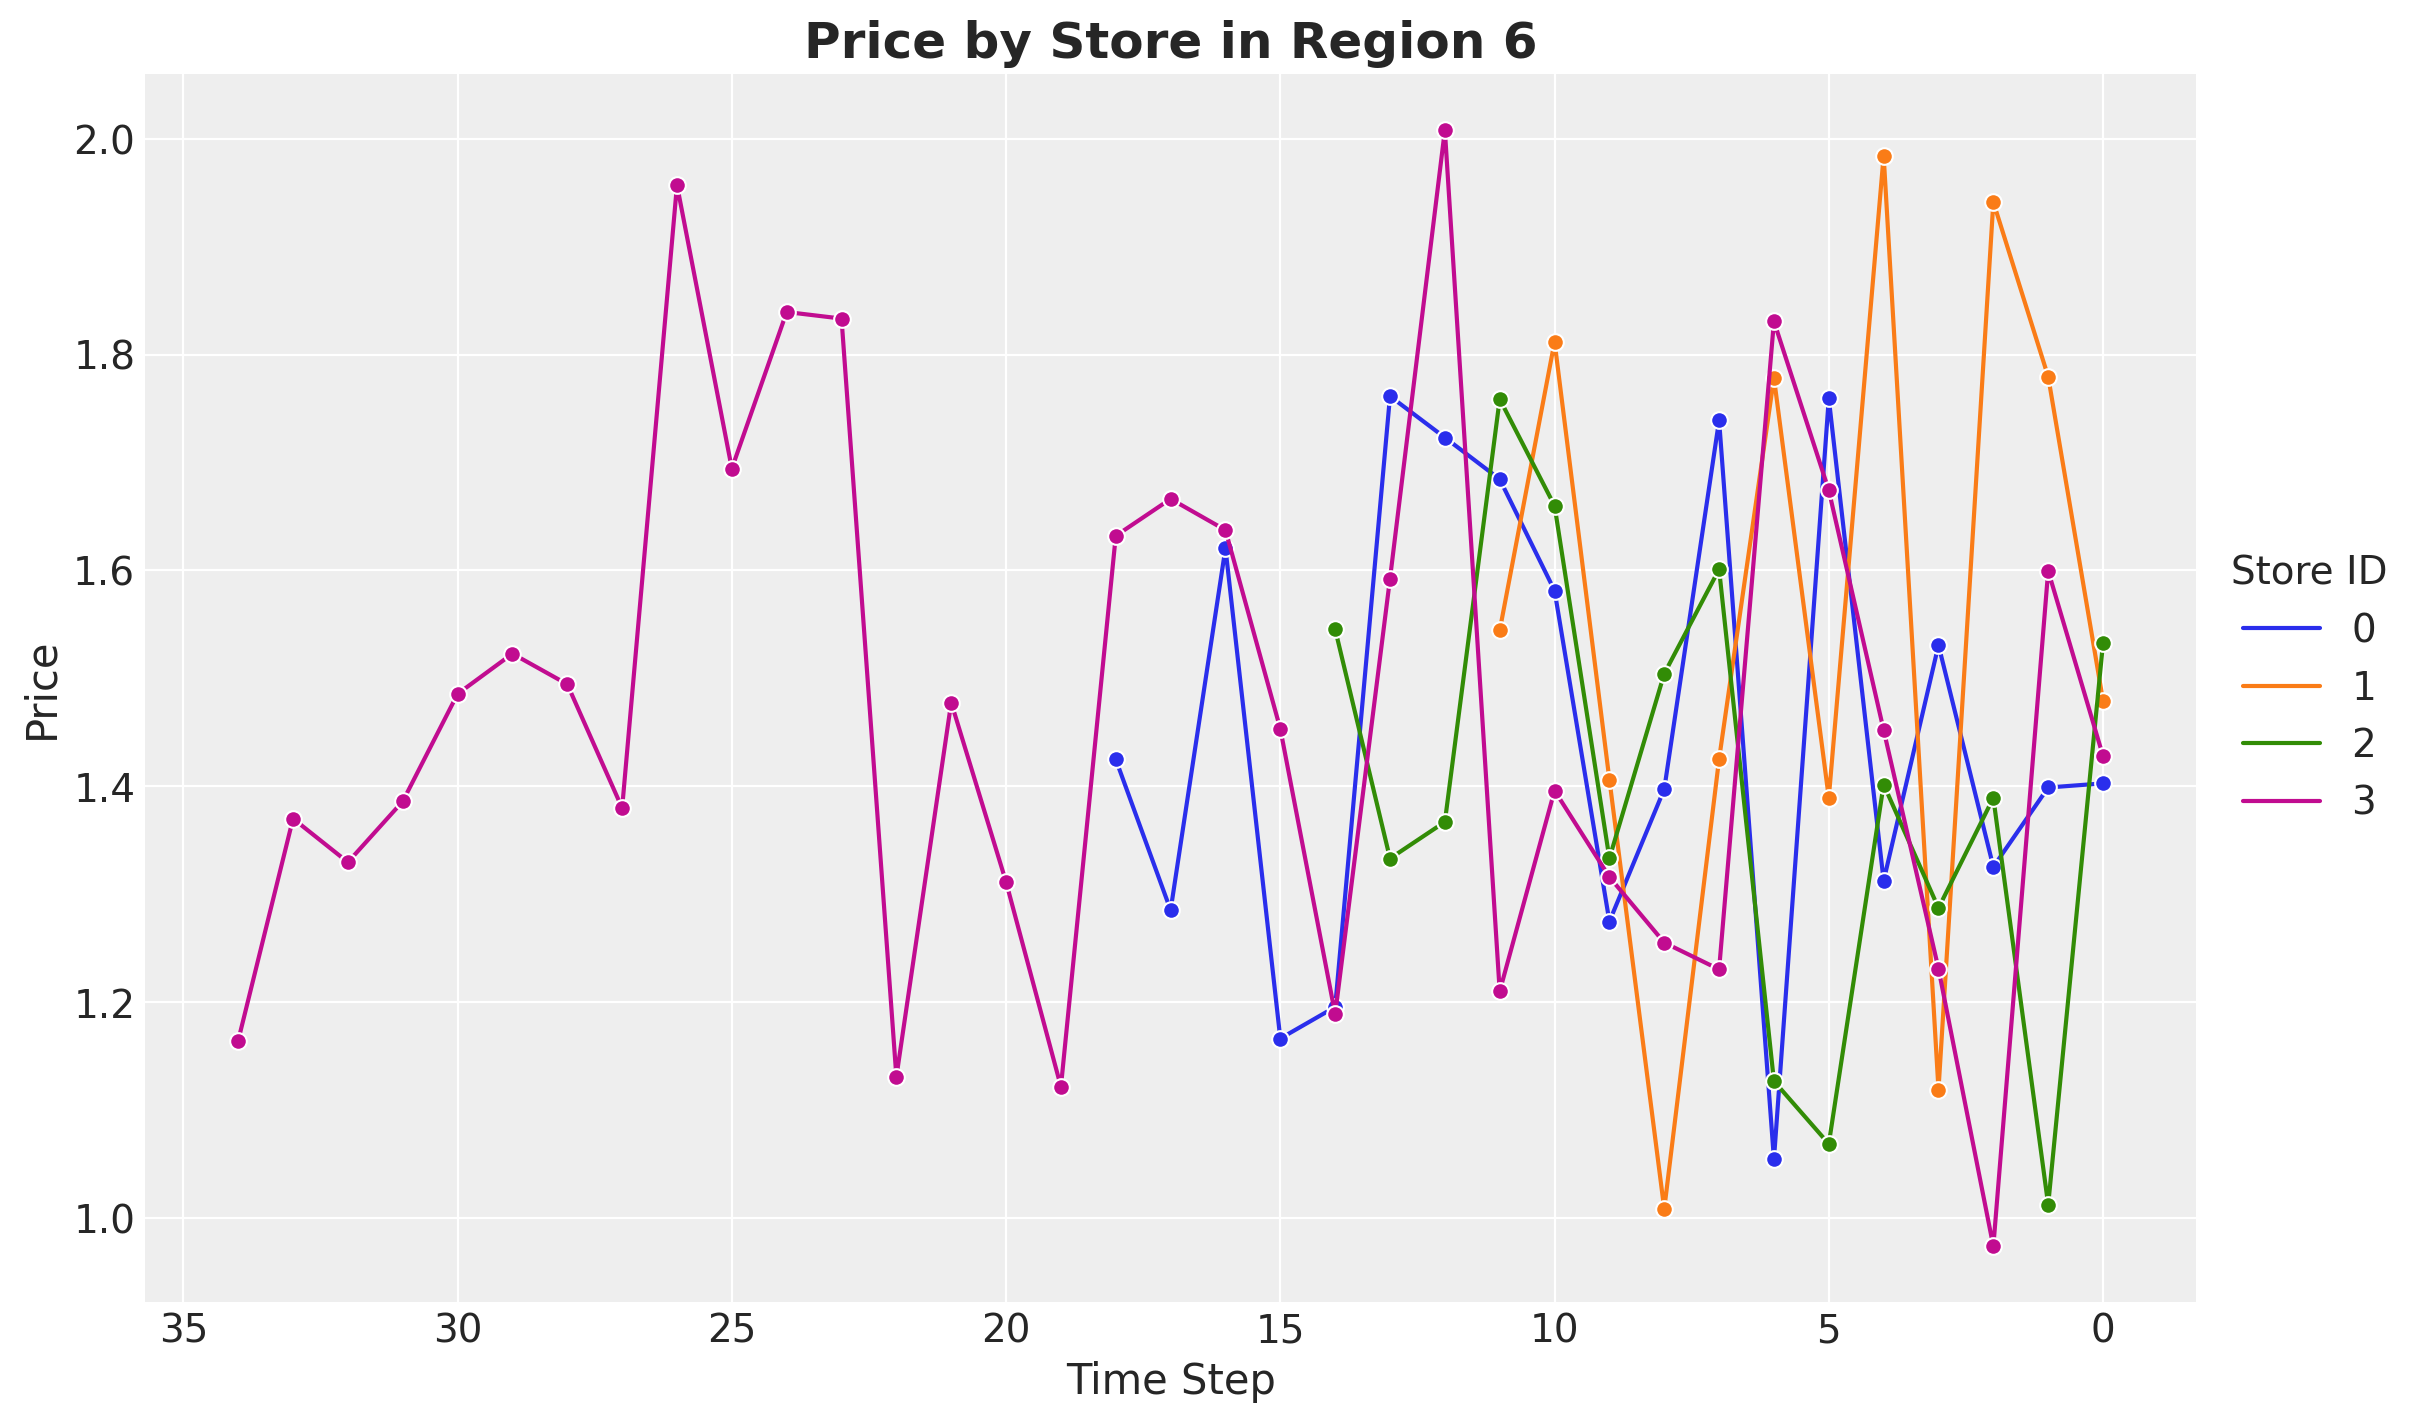

In [12]:
fig, ax = plt.subplots()
sns.lineplot(
    data=market_df.query("region_id == 6").assign(
        store_id=lambda x: x["store_id"].astype("category")
    ),
    x="time_step",
    y="price",
    hue="store_id",
    marker="o",
)
ax.invert_xaxis()
ax.legend(
    title="Store ID", title_fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5)
)
ax.set(xlabel="Time Step", ylabel="Price")
ax.set_title(label="Price by Store in Region 6", fontsize=18, fontweight="bold")

---
## Part 2: Multilevel Elasticities Model

In [13]:
obs = market_df.index.to_numpy()
price = market_df["price"].to_numpy()
log_price = market_df["log_price"].to_numpy()
quantities = market_df["quantities"].to_numpy()
log_quantities = market_df["log_quantities"].to_numpy()
median_income_idx, median_income = market_df["median_income"].factorize(sort=True)
store_idx, store = market_df["region_store_id"].factorize(sort=True)
region_idx, region = market_df["region_id"].factorize(sort=True)


### Multilevel Model

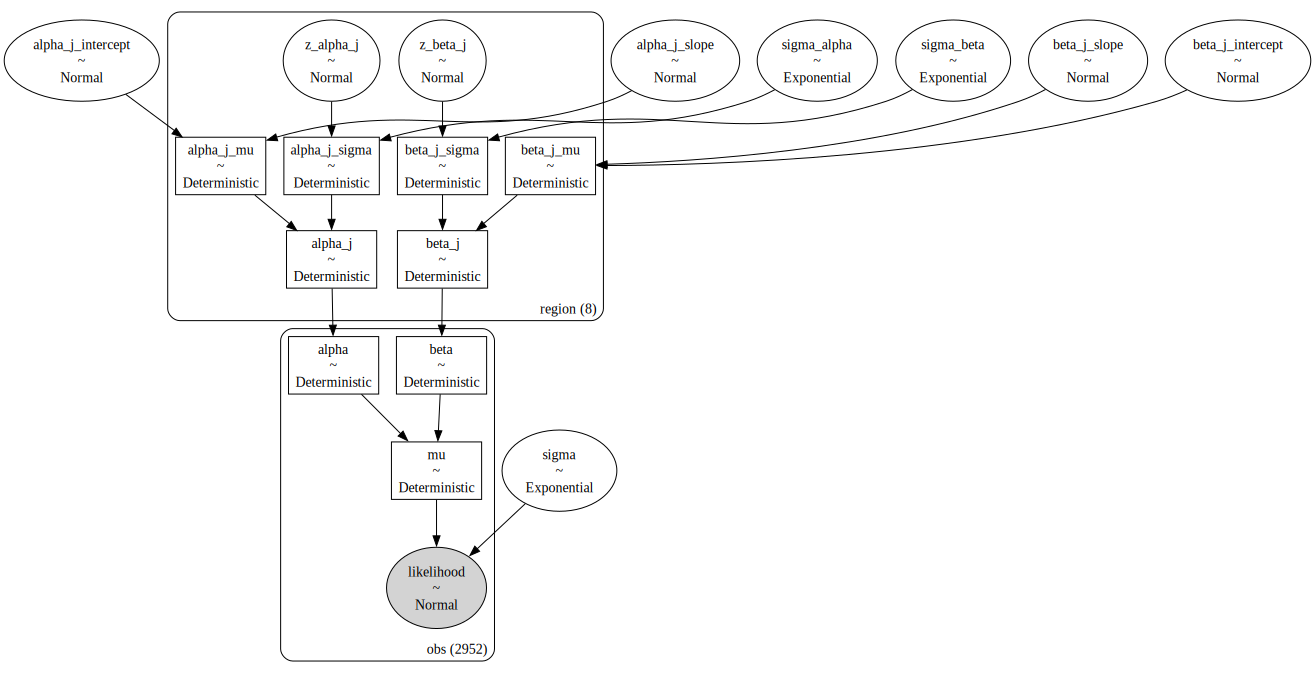

In [14]:
coords = {"store": store, "region": region, "obs": obs}

with pm.Model(coords=coords) as model:
    # --- Priors ---

    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)
    alpha_j_slope = pm.Normal(name="alpha_j_slope", mu=0, sigma=1)
    sigma_alpha = pm.Exponential(name="sigma_alpha", lam=1 / 0.1)
    z_alpha_j = pm.Normal(name="z_alpha_j", mu=0, sigma=1, dims="region")

    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)
    beta_j_slope = pm.Normal(name="beta_j_slope", mu=0, sigma=1)
    sigma_beta = pm.Exponential(name="sigma_beta", lam=1 / 0.1)
    z_beta_j = pm.Normal(name="z_beta_j", mu=0, sigma=1, dims="region")

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    # --- Parametrization ---

    alpha_j_mu = pm.Deterministic(
        name="alpha_j_mu",
        var=alpha_j_intercept + alpha_j_slope * median_income.to_numpy(),
        dims="region",
    )
    alpha_j_sigma = pm.Deterministic(
        name="alpha_j_sigma", var=sigma_alpha * z_alpha_j, dims="region"
    )
    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=alpha_j_mu + alpha_j_sigma,
        dims="region",
    )

    beta_j_mu = pm.Deterministic(
        name="beta_j_mu",
        var=beta_j_intercept + beta_j_slope * median_income.to_numpy(),
        dims="region",
    )
    beta_j_sigma = pm.Deterministic(
        name="beta_j_sigma", var=sigma_beta * z_beta_j, dims="region"
    )
    beta_j = pm.Deterministic(
        name="beta_j",
        var=beta_j_mu + beta_j_sigma,
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price, dims="obs")

    # --- Likelihood ---

    pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=log_quantities, dims="obs"
    )

pm.model_to_graphviz(model=model)


In [15]:
with model:
    idata = pm.sample(
        target_accept=0.95,
        draws=5_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.193335
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:05:18.628408
Transforming variables...
Transformation time =  0:00:02.079018


Sampling: [likelihood]


In [16]:
idata["sample_stats"]["diverging"].sum().item()


0

In [17]:
var_names = [
    "alpha_j_intercept",
    "alpha_j_slope",
    "beta_j_intercept",
    "beta_j_slope",
    "alpha_j",
    "beta_j",
    "sigma",
]

az.summary(data=idata, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_j_intercept  2.273  0.684   0.958    3.501      0.008    0.006   
alpha_j_slope      0.086  0.106  -0.108    0.288      0.001    0.001   
beta_j_intercept  -1.897  0.890  -3.597   -0.250      0.010    0.007   
beta_j_slope      -0.283  0.140  -0.549   -0.022      0.002    0.001   
alpha_j[0]         2.765  0.043   2.682    2.844      0.000    0.000   
alpha_j[1]         2.935  0.074   2.798    3.076      0.000    0.000   
alpha_j[2]         2.435  0.025   2.389    2.481      0.000    0.000   
alpha_j[3]         3.607  0.047   3.519    3.694      0.000    0.000   
alpha_j[4]         3.010  0.026   2.960    3.059      0.000    0.000   
alpha_j[5]         2.760  0.060   2.650    2.876      0.000    0.000   
alpha_j[6]         3.044  0.075   2.903    3.186      0.000    0.000   
alpha_j[7]         2.330  0.036   2.260    2.398      0.000    0.000   
beta_j[0]         -3.593  0.103  -3.782   -3.393      0.001    0.000   
beta_j[1]         -3.952  0.164  -4.263   -3.648      0.001    0.001   
beta_j[2]         -2.919  0.058  -3.025   -2.810      0.000    0.000   
beta_j[3]         -5.290  0.111  -5.500   -5.082      0.001    0.000   
beta_j[4]         -4.124  0.063  -4.245   -4.010      0.000    0.000   
beta_j[5]         -3.731  0.141  -3.994   -3.462      0.001    0.001   
beta_j[6]         -4.143  0.185  -4.485   -3.793      0.001    0.001   
beta_j[7]         -2.768  0.085  -2.933   -2.613      0.001    0.000   
sigma              0.294  0.004   0.287    0.301      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
alpha_j_intercept    6871.0    9010.0    1.0  
alpha_j_slope        7007.0    9634.0    1.0  
beta_j_intercept     8503.0   12040.0    1.0  
beta_j_slope         8636.0   12568.0    1.0  
alpha_j[0]          26009.0   19706.0    1.0  
alpha_j[1]          33017.0   18957.0    1.0  
alpha_j[2]          25687.0   21016.0    1.0  
alpha_j[3]          24395.0   20414.0    1.0  
alpha_j[4]          25345.0   21301.0    1.0  
alpha_j[5]          34709.0   19527.0    1.0  
alpha_j[6]          36384.0   20046.0    1.0  
alpha_j[7]          25591.0   20089.0    1.0  
beta_j[0]           26622.0   19195.0    1.0  
beta_j[1]           33268.0   17339.0    1.0  
beta_j[2]           25613.0   20797.0    1.0  
beta_j[3]           25515.0   20764.0    1.0  
beta_j[4]           25819.0   21334.0    1.0  
beta_j[5]           34497.0   19596.0    1.0  
beta_j[6]           37598.0   19037.0    1.0  
beta_j[7]           25390.0   19287.0    1.0  
sigma               32812.0   17062.0    1.0

Text(0.5, 0.98, 'Model - Trace')

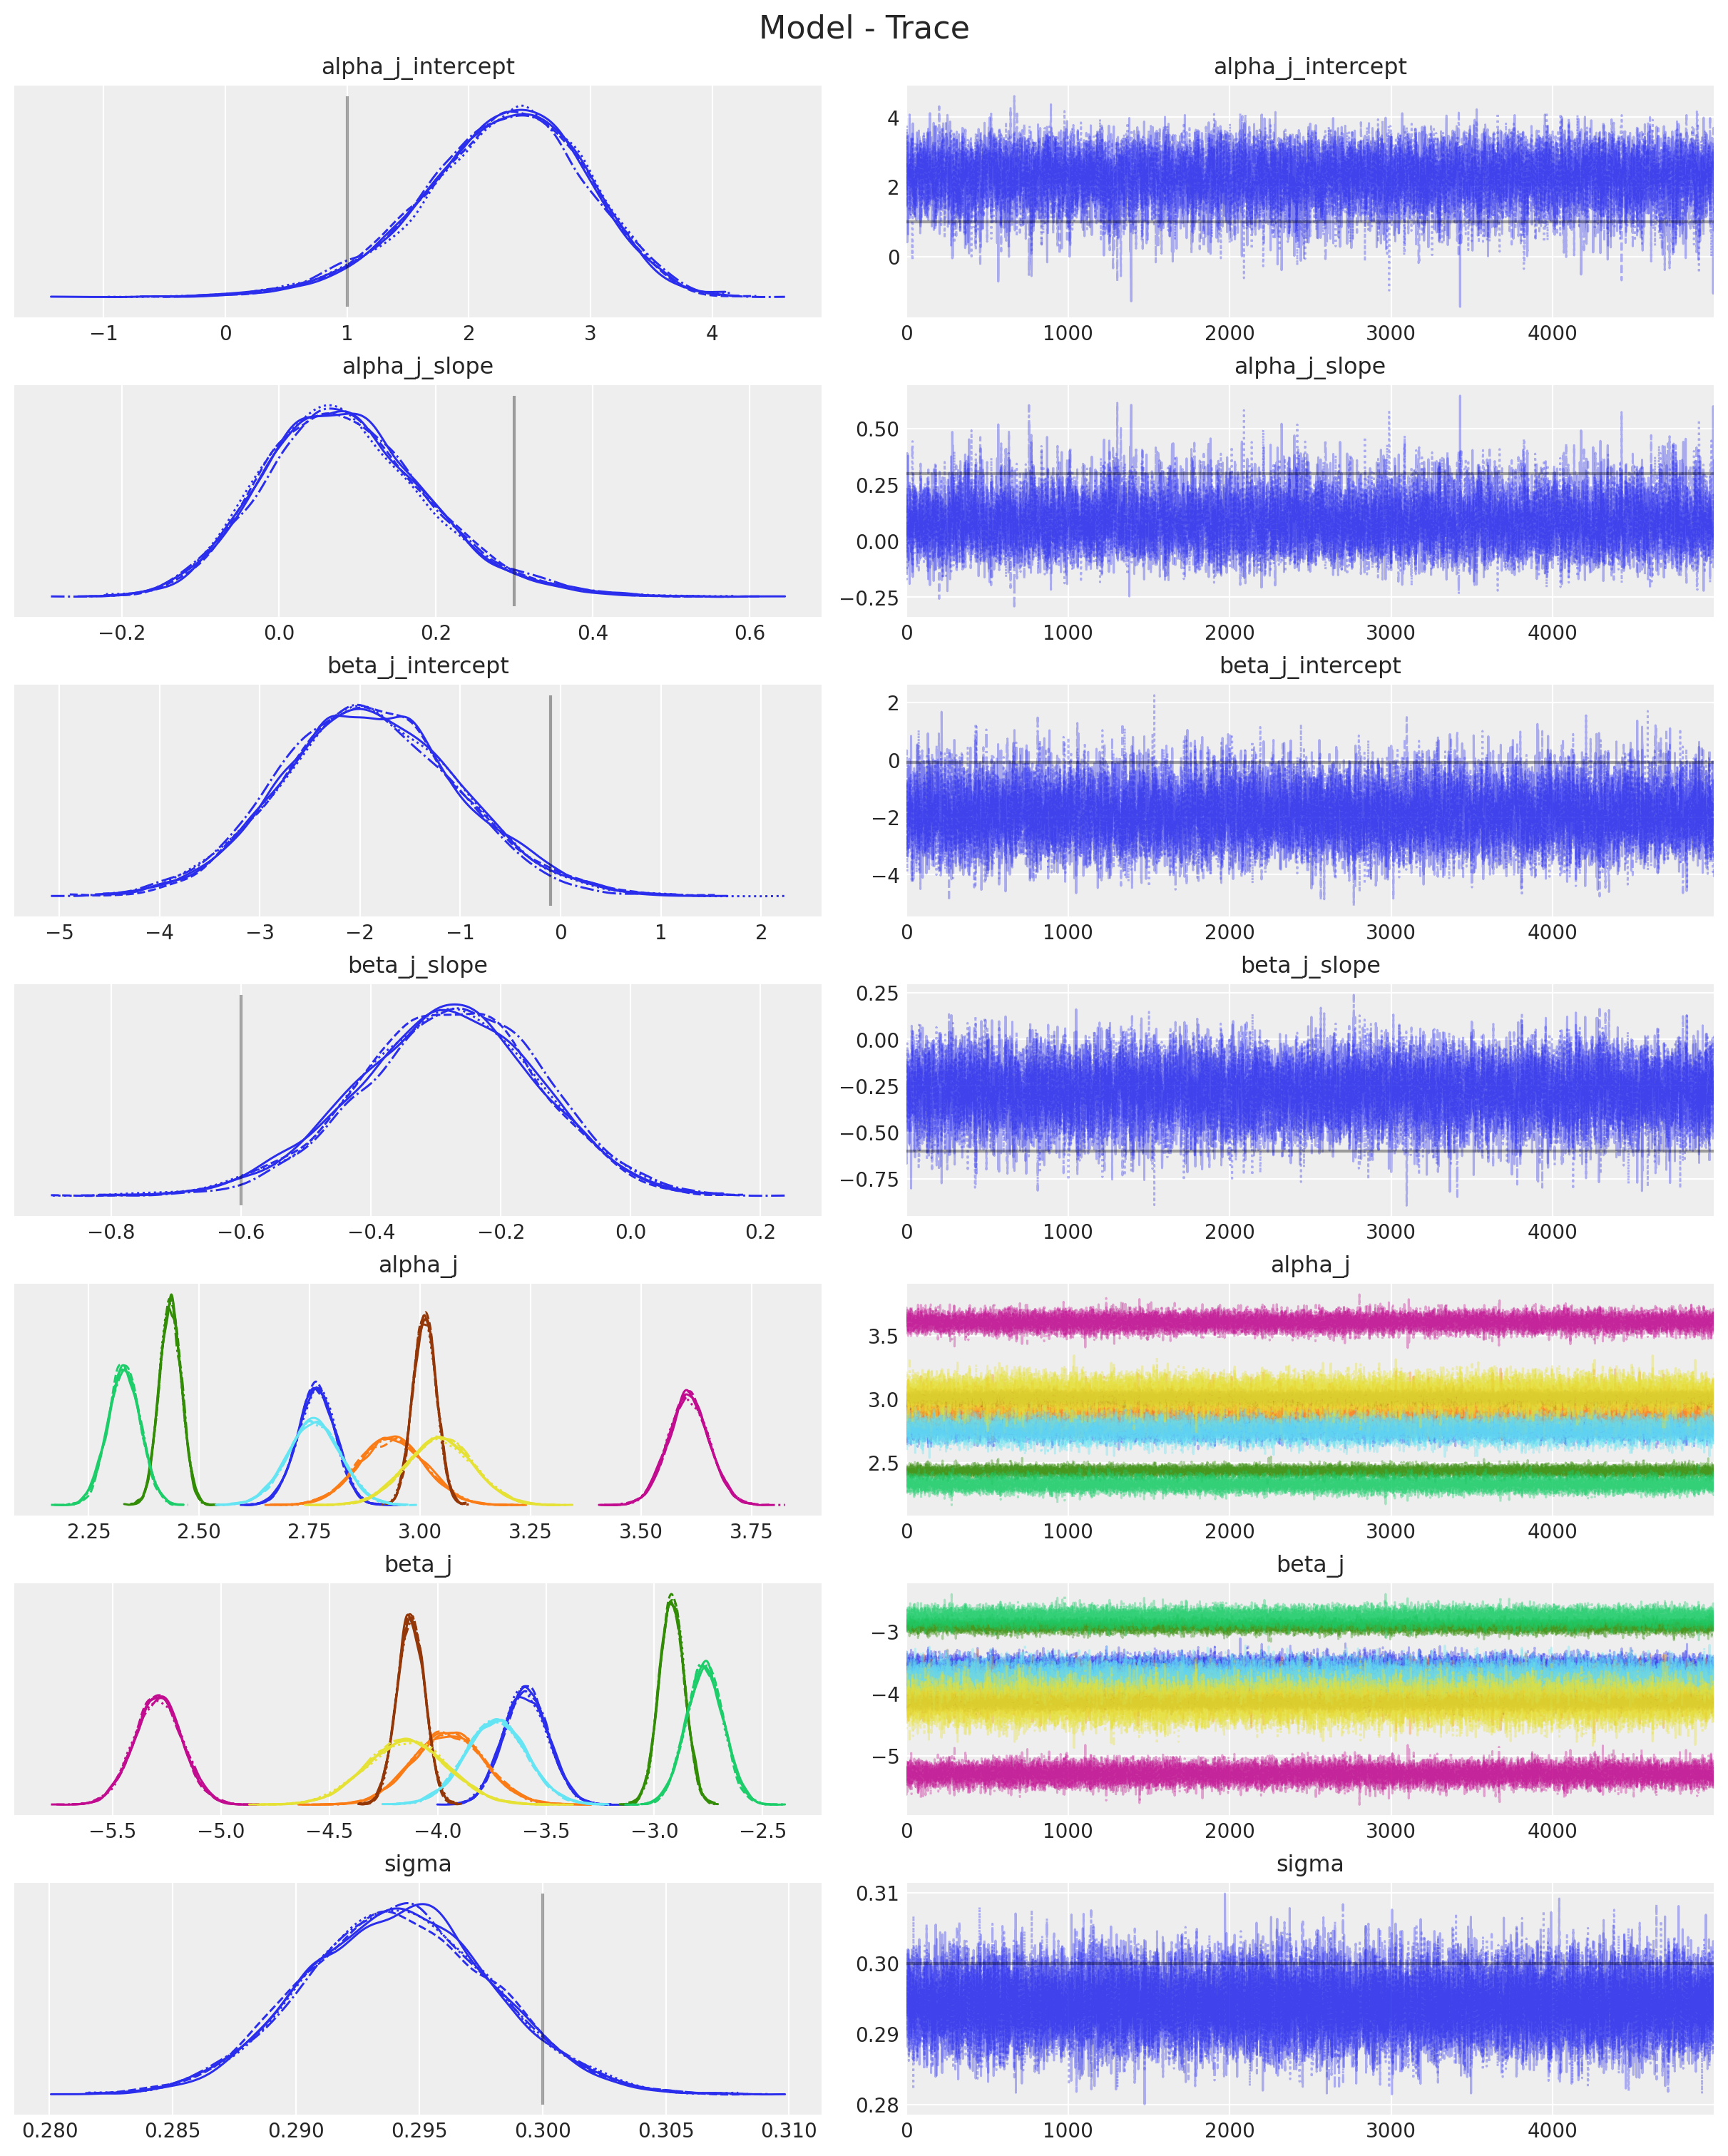

In [18]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    lines=[
        ("alpha_j_intercept", {}, data_generator.intercepts_lr_config.intercept),
        ("alpha_j_slope", {}, data_generator.intercepts_lr_config.slope),
        ("beta_j_intercept", {}, data_generator.slopes_lr_config.intercept),
        ("beta_j_slope", {}, data_generator.slopes_lr_config.slope),
        ("sigma", {}, data_generator.epsilon),
    ],
    compact=True,
    # kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace", fontsize=16)

array([[<Axes: ylabel='alpha_j_slope'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_j_intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha_j_intercept', ylabel='beta_j_slope'>,
        <Axes: xlabel='alpha_j_slope'>,
        <Axes: xlabel='beta_j_intercept'>]], dtype=object)

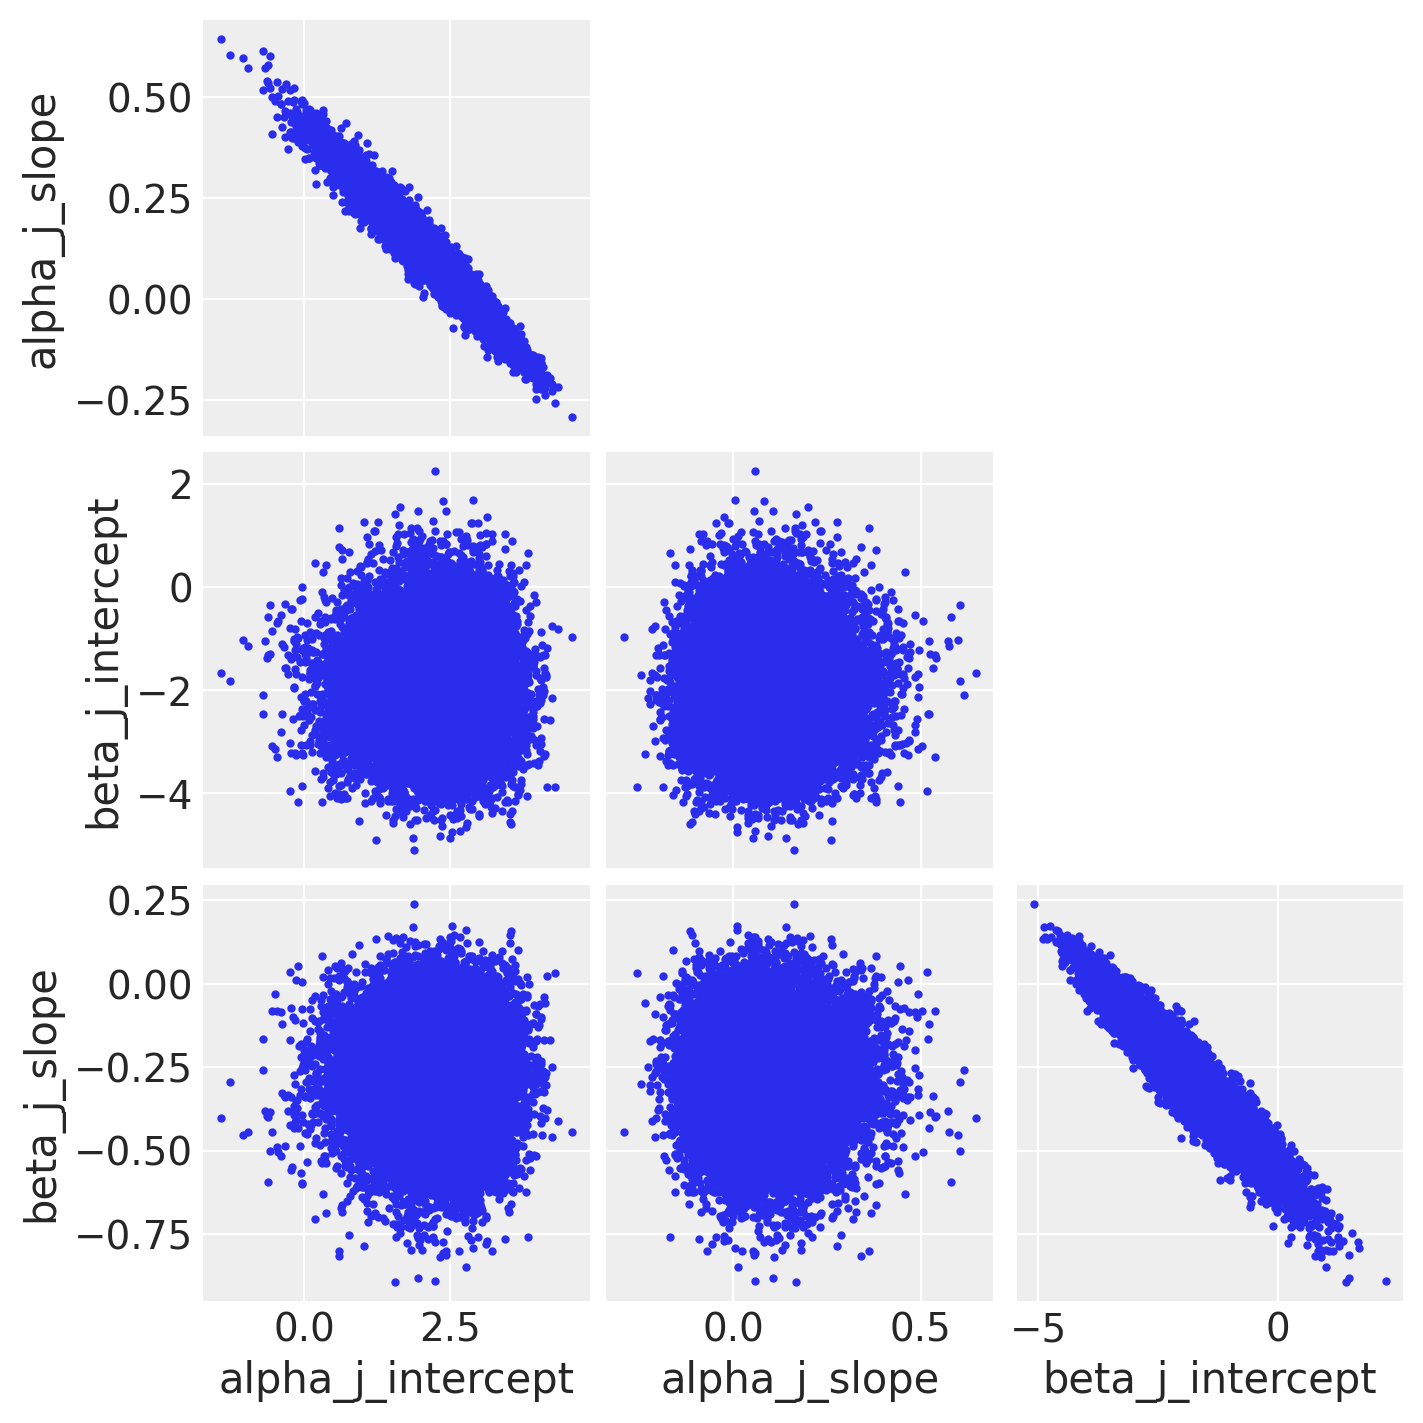

In [19]:
az.plot_pair(
    data=idata,
    var_names=[
        "alpha_j_intercept",
        "alpha_j_slope",
        "beta_j_intercept",
        "beta_j_slope",
    ],
    figsize=(7, 7),
)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

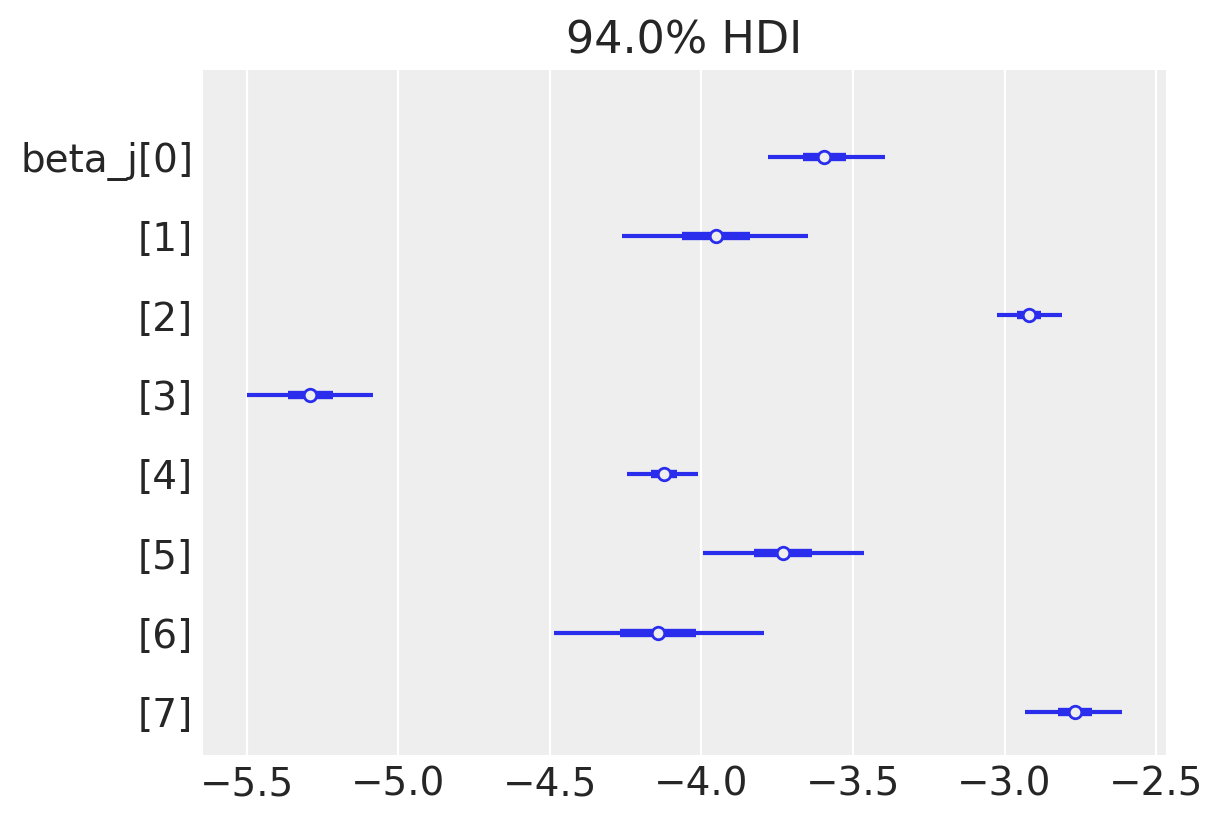

In [20]:
az.plot_forest(
    data=idata,
    var_names=["beta_j"],
    combined=True,
    figsize=(6, 4),
)


In [21]:
# ax = az.plot_ppc(
#     data=posterior_predictive,
#     observed_rug=True,
#     random_seed=seed,
# )
# ax.set(
#     title="Posterior Predictive Check",
#     xlabel="likelihood",
#     # xlim=(-0.5, 1.5),
# )

### Multilevel Model with Correlated Random Effects

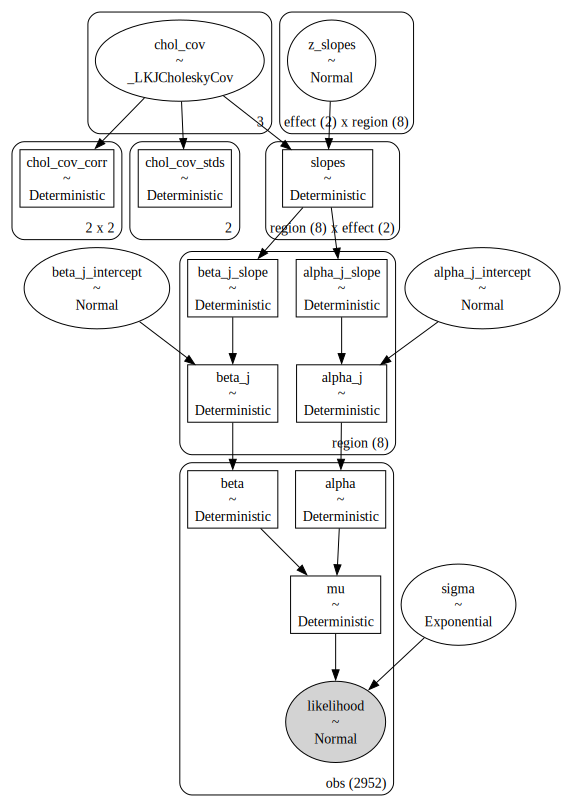

In [26]:
import pytensor.tensor as pt

# https://tomicapretto.github.io/posts/2022-06-12_lkj-prior/#model-3-correlated-priors-with-lkjcorr.

coords = {
    "store": store,
    "region": region,
    "obs": obs,
    "effect": ["intercept", "slope"],
}

with pm.Model(coords=coords) as model_cov:
    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)

    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)

    sd_dist = pm.HalfNormal.dist(sigma=0.01, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    z_slopes = pm.Normal(name="z_slopes", mu=0, sigma=1, dims=("effect", "region"))
    slopes = pm.Deterministic(
        name="slopes", var=pt.dot(chol, z_slopes).T, dims=("region", "effect")
    )

    alpha_j_slope = pm.Deterministic(
        name="alpha_j_slope", var=slopes[:, 0], dims="region"
    )

    beta_j_slope = pm.Deterministic(
        name="beta_j_slope", var=slopes[:, 1], dims="region"
    )

    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=alpha_j_intercept + alpha_j_slope * median_income.to_numpy(),
        dims="region",
    )

    beta_j = pm.Deterministic(
        name="beta_j",
        var=beta_j_intercept + beta_j_slope * median_income.to_numpy(),
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price, dims="obs")

    # --- Likelihood ---

    pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=log_quantities, dims="obs"
    )

pm.model_to_graphviz(model=model_cov)

In [27]:
with model_cov:
    idata_cov = pm.sample(
        target_accept=0.90,
        draws=5_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_cov = pm.sample_posterior_predictive(
        trace=idata_cov, random_seed=rng
    )


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:05.081794
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:47.185275
Transforming variables...
Transformation time =  0:00:02.213819


Sampling: [likelihood]


In [28]:
idata_cov["sample_stats"]["diverging"].sum().item()


0

In [29]:
var_names = [
    "alpha_j_intercept",
    # "alpha_j_slope",
    "beta_j_intercept",
    # "beta_j_slope",
    "slopes",
    "alpha_j",
    "beta_j",
    "sigma",
]

az.summary(data=idata_cov, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_j_intercept     2.849  0.057   2.743    2.957      0.001    0.001   
beta_j_intercept     -3.783  0.113  -3.998   -3.573      0.001    0.001   
slopes[0, intercept] -0.015  0.014  -0.042    0.011      0.000    0.000   
slopes[0, slope]      0.032  0.029  -0.022    0.086      0.000    0.000   
slopes[1, intercept]  0.016  0.016  -0.014    0.047      0.000    0.000   
slopes[1, slope]     -0.031  0.032  -0.091    0.031      0.000    0.000   
slopes[2, intercept] -0.069  0.010  -0.088   -0.049      0.000    0.000   
slopes[2, slope]      0.142  0.021   0.103    0.182      0.000    0.000   
slopes[3, intercept]  0.117  0.012   0.096    0.139      0.000    0.000   
slopes[3, slope]     -0.230  0.024  -0.274   -0.183      0.000    0.000   
slopes[4, intercept]  0.024  0.009   0.006    0.041      0.000    0.000   
slopes[4, slope]     -0.050  0.019  -0.085   -0.015      0.000    0.000   
slopes[5, intercept] -0.014  0.011  -0.035    0.008      0.000    0.000   
slopes[5, slope]      0.014  0.024  -0.032    0.060      0.000    0.000   
slopes[6, intercept]  0.025  0.012   0.002    0.047      0.000    0.000   
slopes[6, slope]     -0.046  0.026  -0.095    0.001      0.000    0.000   
slopes[7, intercept] -0.058  0.007  -0.071   -0.044      0.000    0.000   
slopes[7, slope]      0.113  0.015   0.085    0.142      0.000    0.000   
alpha_j[0]            2.782  0.041   2.702    2.855      0.000    0.000   
alpha_j[1]            2.926  0.066   2.804    3.050      0.000    0.000   
alpha_j[2]            2.446  0.025   2.400    2.493      0.000    0.000   
alpha_j[3]            3.559  0.046   3.473    3.645      0.000    0.000   
alpha_j[4]            3.007  0.026   2.958    3.055      0.000    0.000   
alpha_j[5]            2.758  0.058   2.648    2.868      0.000    0.000   
alpha_j[6]            3.027  0.070   2.892    3.156      0.000    0.000   
alpha_j[7]            2.329  0.036   2.264    2.398      0.000    0.000   
beta_j[0]            -3.641  0.093  -3.816   -3.468      0.000    0.000   
beta_j[1]            -3.933  0.139  -4.195   -3.675      0.001    0.001   
beta_j[2]            -2.951  0.058  -3.059   -2.842      0.000    0.000   
beta_j[3]            -5.175  0.107  -5.375   -4.973      0.001    0.000   
beta_j[4]            -4.115  0.061  -4.228   -4.002      0.000    0.000   
beta_j[5]            -3.692  0.134  -3.946   -3.441      0.001    0.001   
beta_j[6]            -4.112  0.161  -4.412   -3.807      0.001    0.001   
beta_j[7]            -2.767  0.083  -2.919   -2.609      0.000    0.000   
sigma                 0.294  0.004   0.287    0.301      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
alpha_j_intercept       6221.0    9972.0    1.0  
beta_j_intercept        6516.0   10557.0    1.0  
slopes[0, intercept]    8138.0   13582.0    1.0  
slopes[0, slope]        8987.0   14695.0    1.0  
slopes[1, intercept]   12918.0   16734.0    1.0  
slopes[1, slope]       13812.0   16802.0    1.0  
slopes[2, intercept]    6899.0   11185.0    1.0  
slopes[2, slope]        7436.0   12725.0    1.0  
slopes[3, intercept]    8795.0   14114.0    1.0  
slopes[3, slope]       10281.0   15849.0    1.0  
slopes[4, intercept]    6894.0   11510.0    1.0  
slopes[4, slope]        7485.0   12448.0    1.0  
slopes[5, intercept]   10194.0   15419.0    1.0  
slopes[5, slope]       11587.0   15727.0    1.0  
slopes[6, intercept]   11870.0   15983.0    1.0  
slopes[6, slope]       13240.0   17160.0    1.0  
slopes[7, intercept]    7682.0   13111.0    1.0  
slopes[7, slope]        8576.0   13715.0    1.0  
alpha_j[0]             36190.0   20550.0    1.0  
alpha_j[1]             32489.0   19137.0    1.0  
alpha_j[2]             28283.0   20583.0    1.0  
alpha_j[3]             32443.0   19895.0    1.0  
alpha_j[4]             30318.0   22094.0    1.0  
alpha_j[5]             35404.0   19067.0    1.0  
alpha_j[6]             33905.0   19033.0    1.0  
alpha_j[7]            

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'alpha_j_slope', 'beta_j_slope'} expected from {'alpha_j_intercept', 'sigma', 'slopes', 'alpha_j', 'beta_j', 'beta_j_intercept'}
  warnings.warn(


Text(0.5, 0.98, 'Model - Trace')

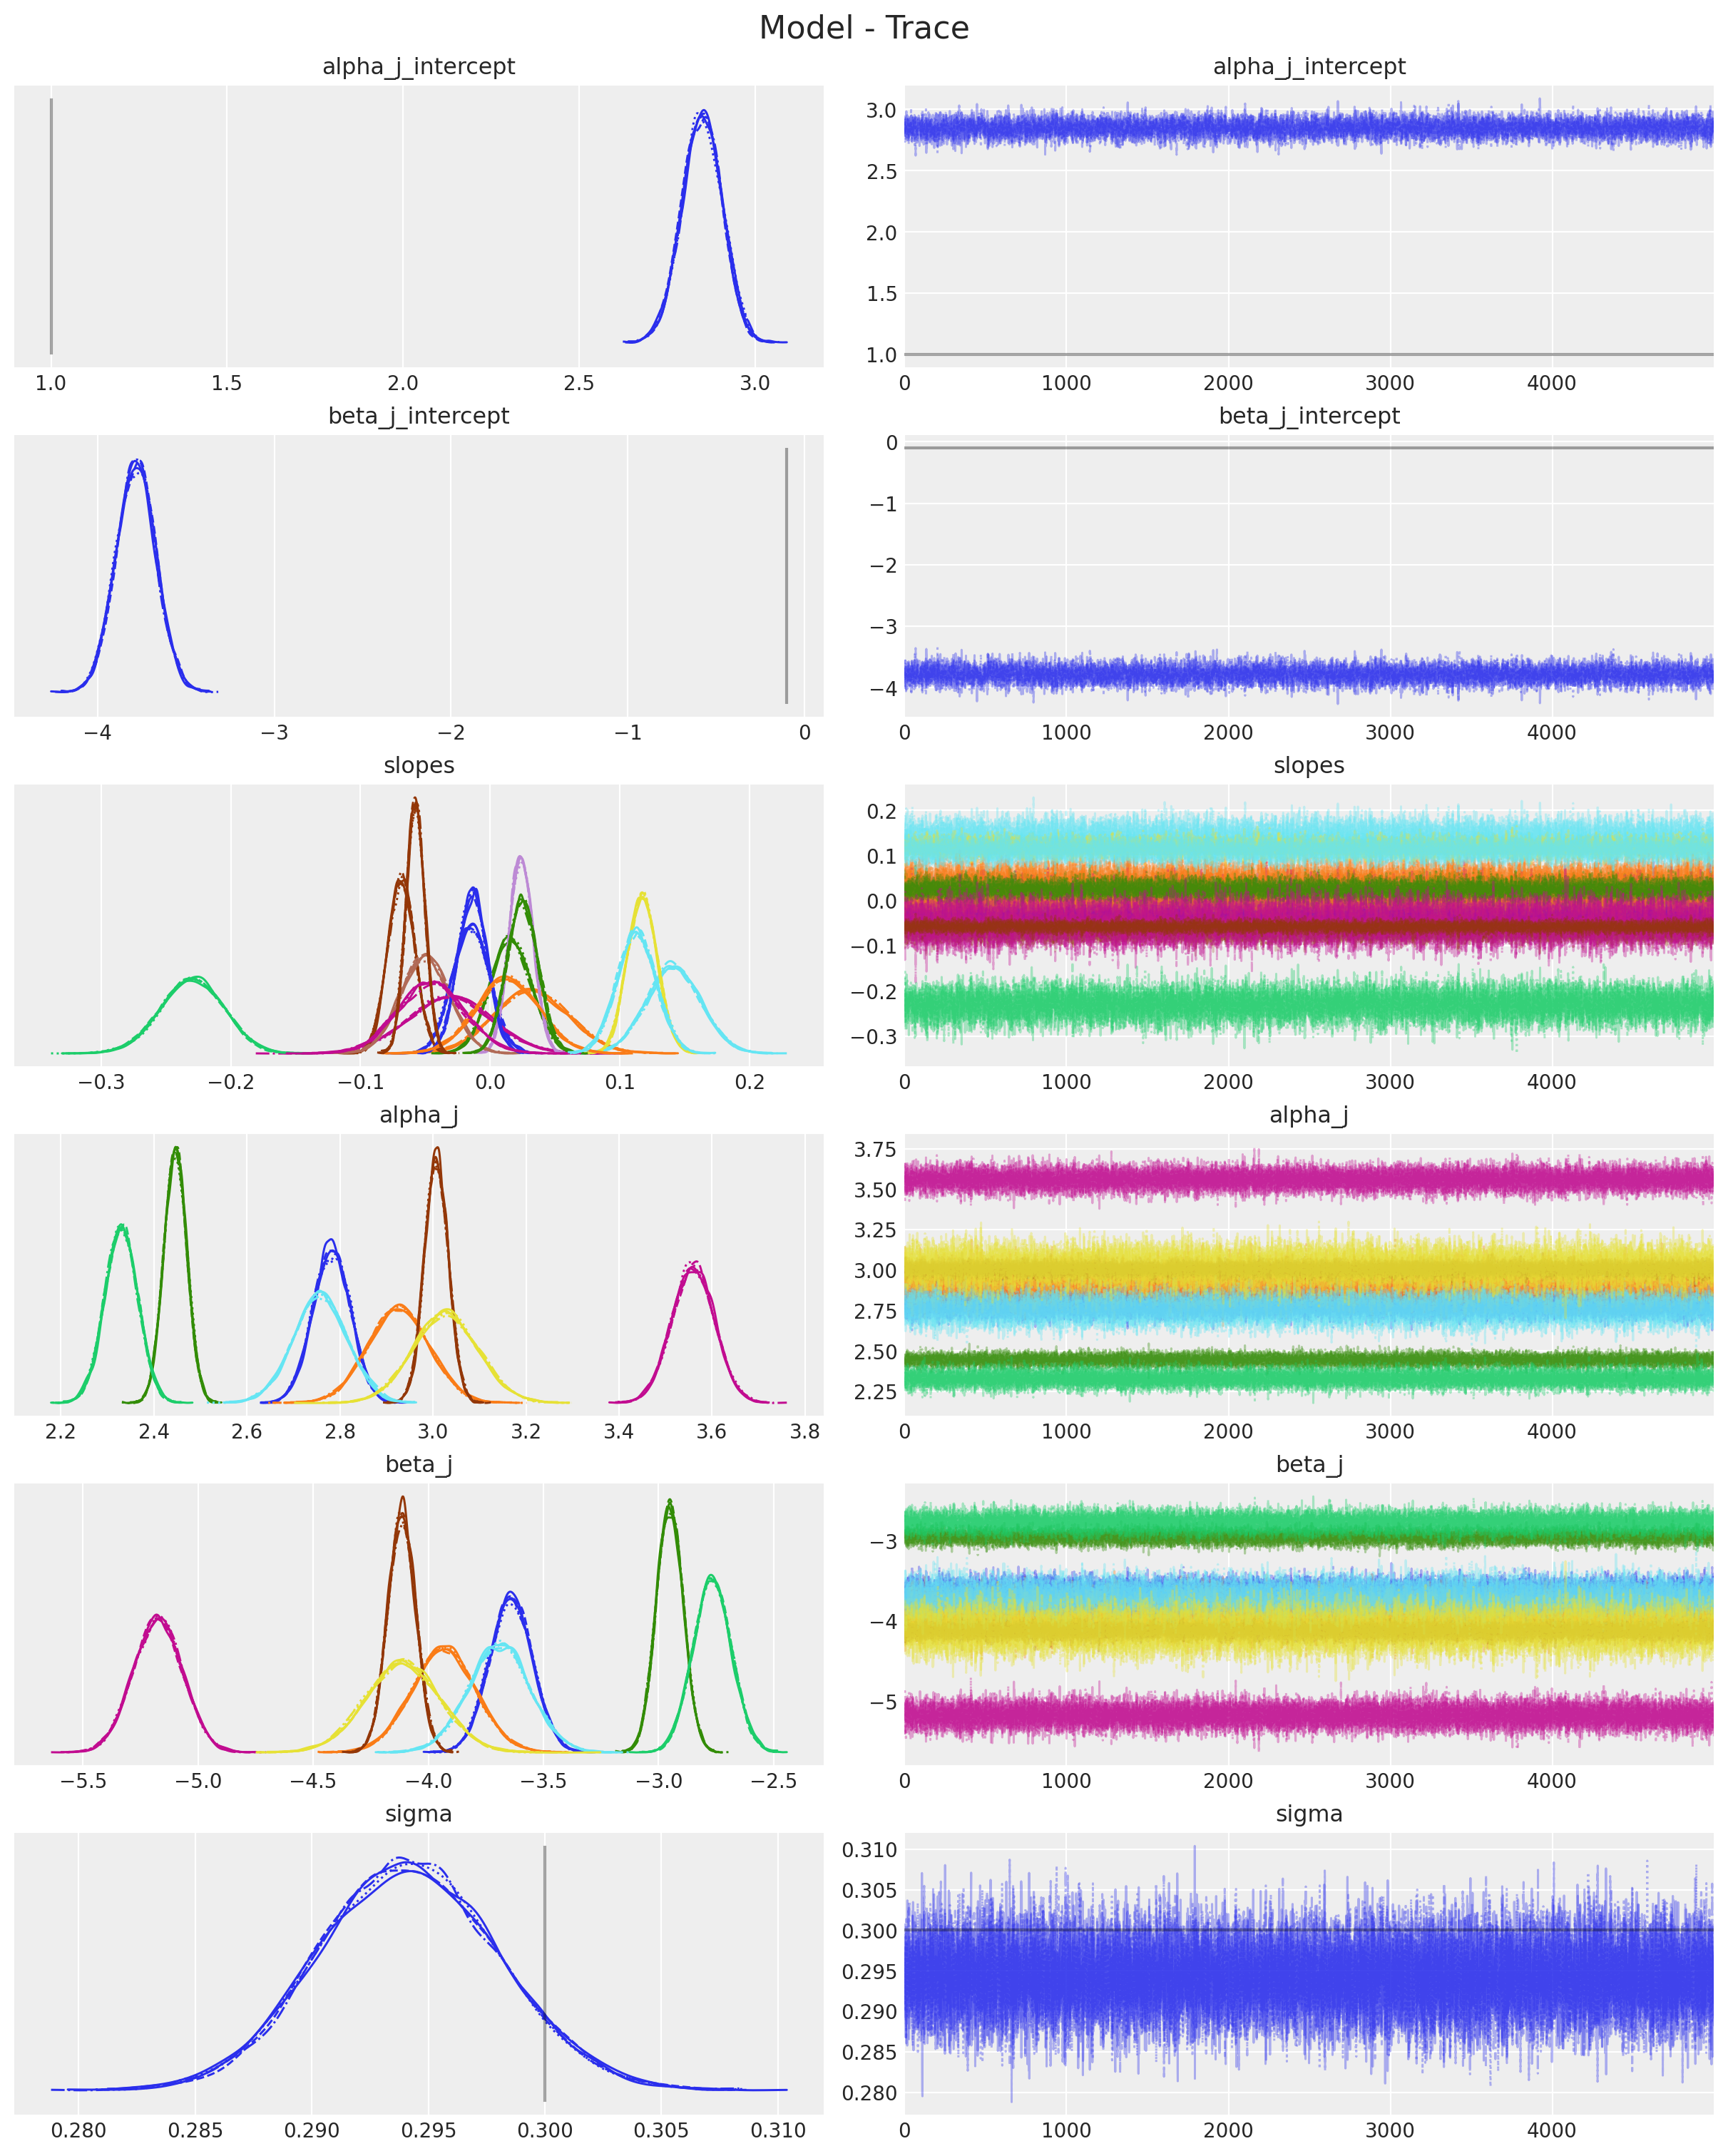

In [30]:
axes = az.plot_trace(
    data=idata_cov,
    var_names=var_names,
    lines=[
        ("alpha_j_intercept", {}, data_generator.intercepts_lr_config.intercept),
        ("alpha_j_slope", {}, data_generator.intercepts_lr_config.slope),
        ("beta_j_intercept", {}, data_generator.slopes_lr_config.intercept),
        ("beta_j_slope", {}, data_generator.slopes_lr_config.slope),
        ("sigma", {}, data_generator.epsilon),
    ],
    compact=True,
    # kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace", fontsize=16)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

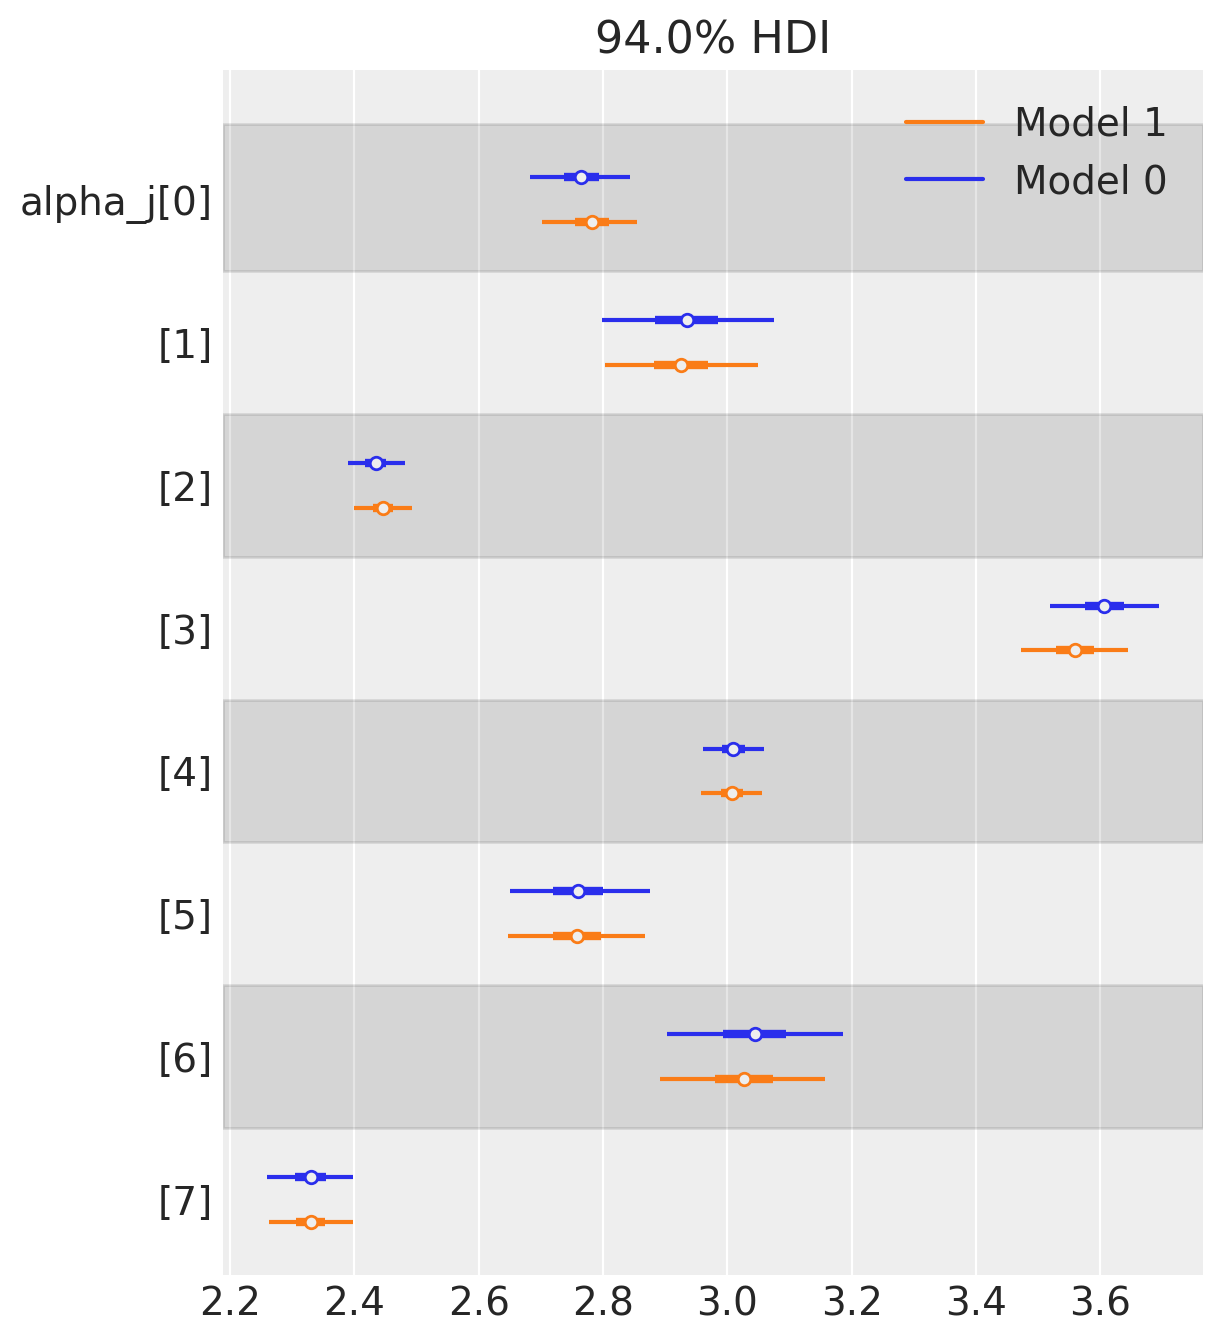

In [31]:
az.plot_forest(data=[idata, idata_cov], var_names=["alpha_j"], combined=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

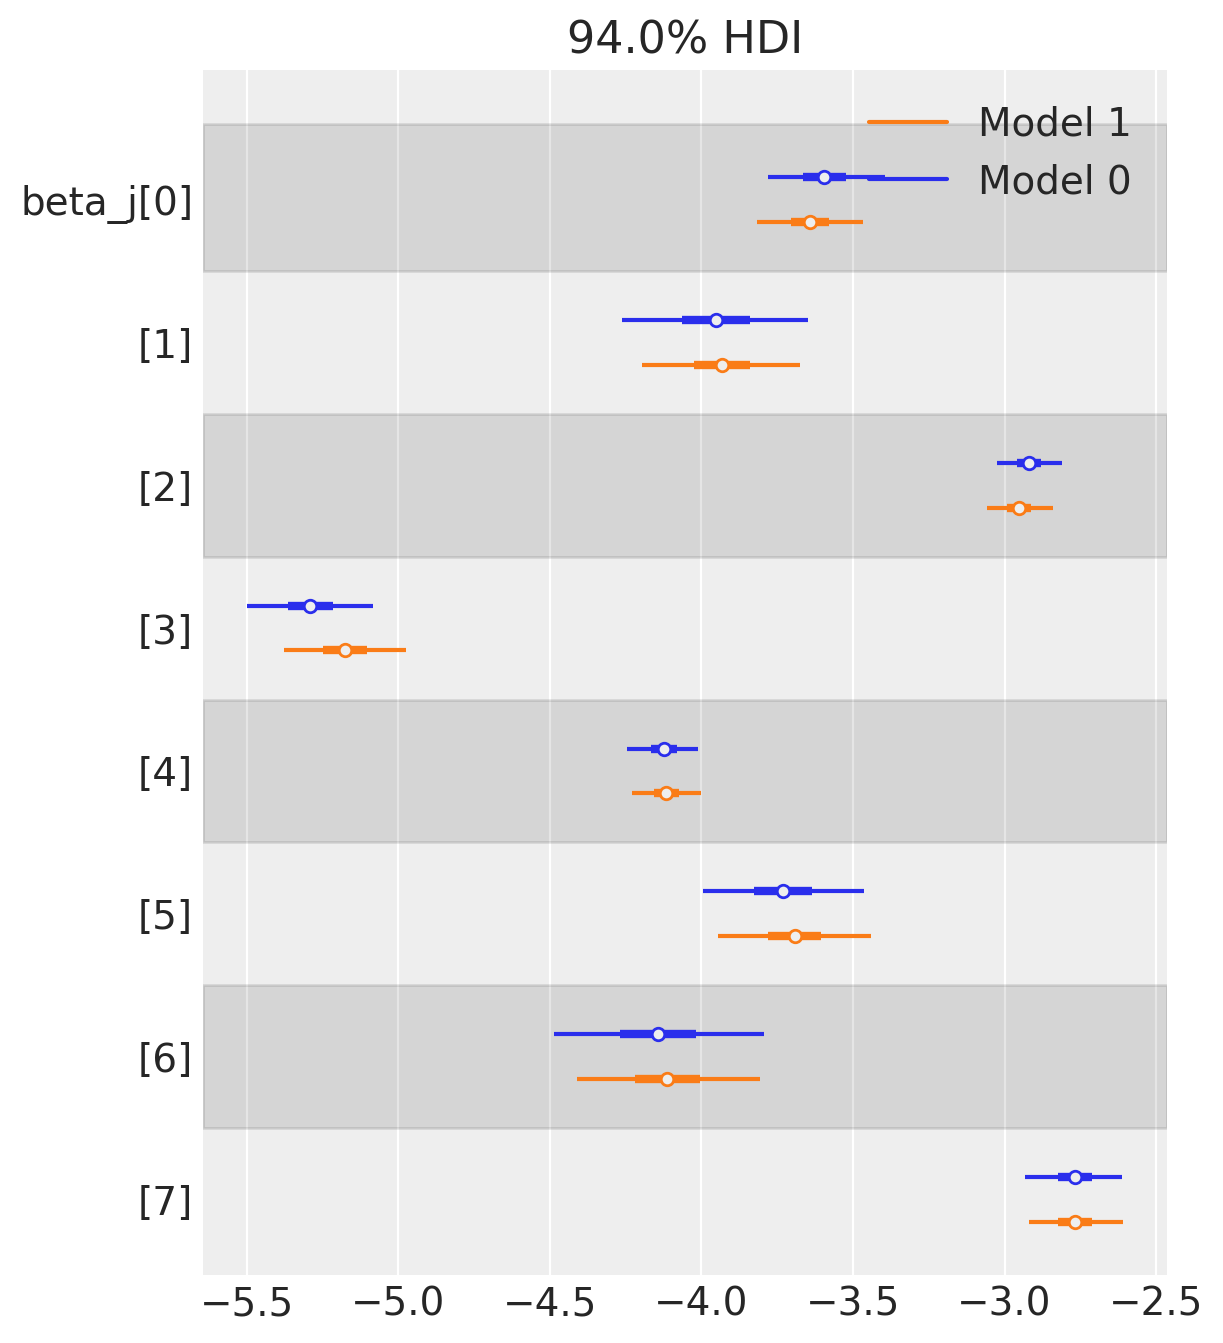

In [32]:
az.plot_forest(data=[idata, idata_cov], var_names=["beta_j"], combined=True)